# Introdução

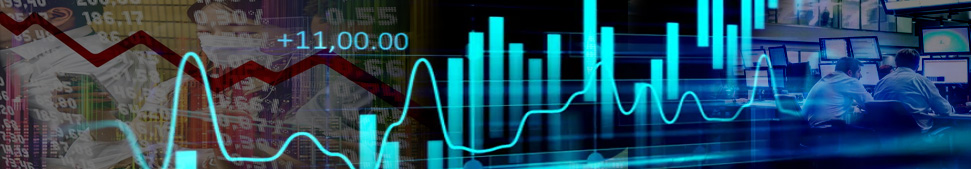

O Indice **Ibovespa** é o principal indicador de desempenho das ações negociadas na Bolsa Brasileira e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 53 anos, consolidou-se como referência para investidores ao redor do mundo [1].


Nessa exploração, iremos analisar como esse índice se comporta e qual a relação entre ele e outros indicadores financeiros, como o S&P500 (Índice das 500 maiores empresas dos EUA), o índice do ouro futuro(GZ), índice do petroleo WTI futuro(TX), o índice Dow Jones e o índice da bolsa Alemã (DAX). Além disso, através de regressão linear e redes neurais, realizaremos uma predição do valor da Ibovespa.


# Objetivos


**Objetivos do notebook:**
- Verificar relação entre Ibovespa e S&P500, GZ, TX, Dow Jones e Dax
- Predizer o preço da Ibovespa para períodos futuros através da regressão linear e redes neurais.
- Transformar os dados em um problema de classificação e predizer Up ou Down dos valores da Ibovespa a partir de outras bolsas e parâmetros.




# Análise Exploratória

In [ ]:
import math 
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

Os dados dessa exploração serão extraídos do serviço *yahoo finance*, para isso, devemos realizar o *'query'* (consulta) dos dados utilizando a notação determinada por esse serviço, para isso, devemos extrair 4 informações:
- o ativo (dados)
- a data inicial
- a data final
- o intervalo (quantos dados por unidade de tempo).


Vale resaltar que a data inicial e final seguem a notação *'Unix epoch time'*, que contabiliza a quantidade de segundos desde a data de criação do sistema UNIX (1 de janeiro de 1970), e para isso, faremos a conversão utilizando a biblioteca time.

O período escolhido para o modelo é entre 01/01/2016 e 31/12/2017 para que possamos validar com os dados de 01/01/2018 a 31/12/2019 

In [ ]:
ativo = '%5EBVSP'
periodoInicial = int(time.mktime((2016, 1, 1, 23, 00, 0,0,0,0)))
periodoFinal = int(time.mktime((2019, 12, 31, 23, 59, 0,0,0,0)))
intervalo = '1d'

Em seguida, podemos utilizar essa informação para realizar um *'query http'* ao serviço *yahoo finance*

In [ ]:
queryBVSP = f'https://query1.finance.yahoo.com/v7/finance/download/{ativo}?period1={periodoInicial}&period2={periodoFinal}&interval={intervalo}&events=history&includeAdjustedClose=true'

Finalmente, podemos ler os dados como um CSV usando pandas e fazer o nosso dataframe ser indexado pelo parâmetro Data.

In [ ]:
dfBVSP = pd.read_csv(queryBVSP)
dfBVSP['Date'] = pd.to_datetime(dfBVSP['Date'])
dfBVSP.set_index('Date', inplace=True)

In [ ]:
dfBVSP.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

Podemos notar que esse dados contem 6 colunas:
- Open (preço de abertura do ativo)
- High (preço mais alto dentro do intervalo)
- Low (preço mais baixo dentro do intervalo)
- Close (preço no fechamento do intervalo)
- Adj Close (preço no fechamento corrigido por desdobramentos e dividendos)
- Volume (total de negociações desse ativo)

Nossos dados contém um total de 997 linhas, ou informações de 997 dias, no *query* foi solicitado aproximadamente 4 anos de dados, porém, não existe negociações sábados, domingos e nem feriados, por isso esse valor é diferente de 4*365 dias

In [ ]:
len(dfBVSP.index)

997

Em seguida, podemos observar preliminarmente o comportamento dos nossos dados no tempo, utilizando o valor do ativo no fechamento.

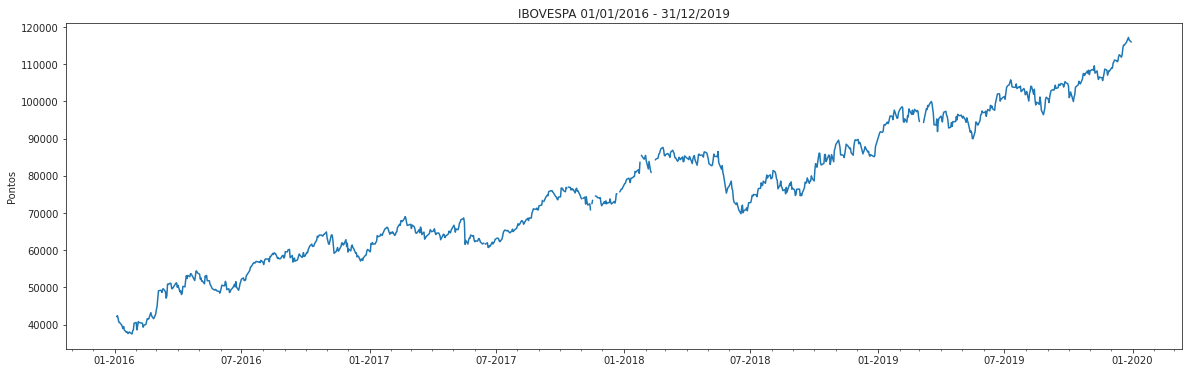

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(dfBVSP.index,dfBVSP.Close)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
#sns.set_style("ticks")
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.title("IBOVESPA 01/01/2016 - 31/12/2019")
plt.ylabel("Pontos")
plt.show()


Podemos ver que existe partes dos dados com intervalos sem dados, para investigarmos, vamos fazer um novo gráfico somente desses intervalos:

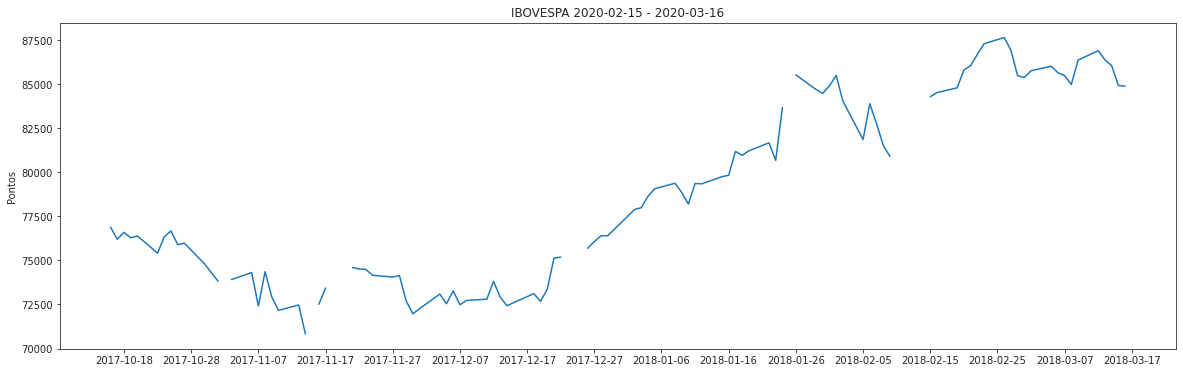

In [ ]:
dfBVSP2 = dfBVSP.loc['2017-10-15':'2018-03-16']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(dfBVSP2.index,dfBVSP2.Close)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
sns.set_style("ticks")
plt.title("IBOVESPA 2020-02-15 - 2020-03-16")
plt.ylabel("Pontos")
plt.show()


Notamos que apesar de ter somente 997 "datas", quando realizamos o gráfico indexado por data, para que o eixo Y seja contínuo, o matplotlib adiciona essas datas porém não plota pontos, pois não existe valor para esses pontos. 

Para facilitar as análises, vamos adicionar essas datas faltantes e realizar uma interpolação polinomial de 5ª ordem, que não deve alterar a tendência geral dos dados e nos possibilitará graficos contínuos

In [ ]:
idx = pd.date_range('2016-01-01', '2019-12-31')
dfBVSP = dfBVSP.reindex(idx)
dfBVSP = dfBVSP.interpolate(method='polynomial', order=5)
dfBVSP.info

<bound method DataFrame.info of                      Open           High  ...      Adj Close        Volume
2016-01-01            NaN            NaN  ...            NaN           NaN
2016-01-02            NaN            NaN  ...            NaN           NaN
2016-01-03            NaN            NaN  ...            NaN           NaN
2016-01-04   43349.000000   43349.000000  ...   42141.000000  2.976300e+06
2016-01-05   42139.000000   42534.000000  ...   42419.000000  2.557200e+06
...                   ...            ...  ...            ...           ...
2019-12-27  117205.000000  117803.000000  ...  116534.000000  3.905900e+06
2019-12-28  118791.976238  118266.772678  ...  115410.506681  1.948542e+06
2019-12-29  119370.586060  118241.352404  ...  114673.289634 -2.354683e+05
2019-12-30  116530.000000  117086.000000  ...  115964.000000  3.667900e+06
2019-12-31            NaN            NaN  ...            NaN           NaN

[1461 rows x 6 columns]>

Realizando novo gráfico dos intervalos 15/10/2017 a 16/03/2018 com os novos valores interpolados:




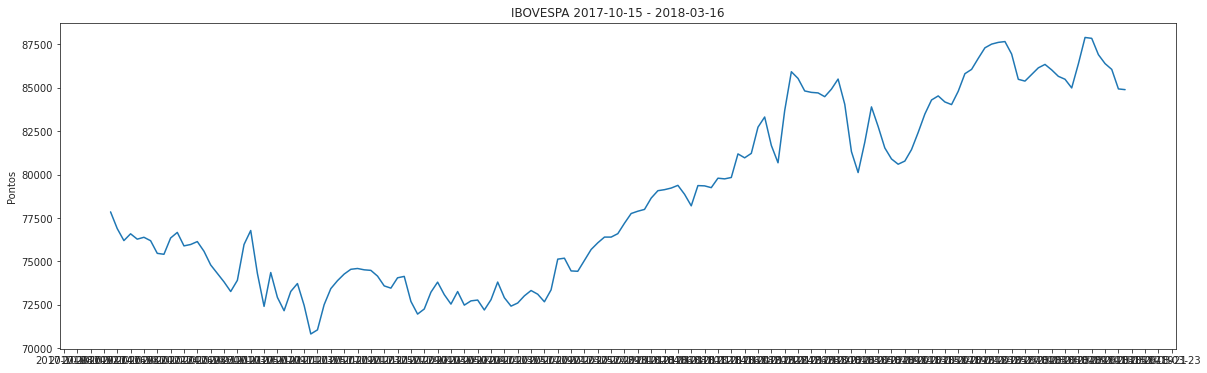

In [ ]:
dfBVSP2 = dfBVSP.loc['2017-10-15':'2018-03-16']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(dfBVSP2.index,dfBVSP2.Close)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
sns.set_style("ticks")
plt.title("IBOVESPA 2017-10-15 - 2018-03-16")
plt.ylabel("Pontos")
plt.show()

Agora vamos importar mais dados para que possamos iniciar as análises. 

1) Importando **Índice Ouro**, em dólar

In [ ]:
ativo = 'GC%3DF'
queryGold = f'https://query1.finance.yahoo.com/v7/finance/download/{ativo}?period1={periodoInicial}&period2={periodoFinal}&interval={intervalo}&events=history&includeAdjustedClose=true'
dfGold = pd.read_csv(queryGold)
dfGold['Date'] = pd.to_datetime(dfGold['Date'])
dfGold.set_index('Date', inplace=True)
dfGold.head

<bound method NDFrame.head of                    Open         High  ...    Adj Close  Volume
Date                                  ...                     
2016-01-04  1063.400024  1082.500000  ...  1075.099976   143.0
2016-01-05  1075.599976  1081.500000  ...  1078.400024    82.0
2016-01-06  1081.599976  1093.699951  ...  1091.900024    52.0
2016-01-07  1091.599976  1109.400024  ...  1107.699951   122.0
2016-01-08  1111.099976  1111.099976  ...  1097.800049    98.0
...                 ...          ...  ...          ...     ...
2019-12-24          NaN          NaN  ...          NaN     NaN
2019-12-26  1505.199951  1512.300049  ...  1509.300049   126.0
2019-12-27  1513.800049  1513.800049  ...  1513.800049   839.0
2019-12-30  1512.599976  1515.099976  ...  1514.500000   446.0
2019-12-31  1513.800049  1523.400024  ...  1519.500000   301.0

[1006 rows x 6 columns]>

É importante notar que a quantidade de dados desse índice é diferente do Ibovespa, visto que ele é indexado em Dolar e consequentemente negociado na bolsa americana, que tem diferentes feriados da bolsa brasileira, reforçando ainda mais a necessidade da interpolação para que possamos unir todos os indicadores no mesmo dataframe

In [ ]:
dfGold = dfGold.reindex(idx)
dfGold = dfGold.interpolate(method='polynomial', order=5)
dfGold.info

<bound method DataFrame.info of                    Open         High  ...    Adj Close       Volume
2016-01-01          NaN          NaN  ...          NaN          NaN
2016-01-02          NaN          NaN  ...          NaN          NaN
2016-01-03          NaN          NaN  ...          NaN          NaN
2016-01-04  1063.400024  1082.500000  ...  1075.099976   143.000000
2016-01-05  1075.599976  1081.500000  ...  1078.400024    82.000000
...                 ...          ...  ...          ...          ...
2019-12-27  1513.800049  1513.800049  ...  1513.800049   839.000000
2019-12-28  1518.744633  1512.334402  ...  1515.900168  1505.188773
2019-12-29  1517.648155  1511.666948  ...  1515.437770  1380.552023
2019-12-30  1512.599976  1515.099976  ...  1514.500000   446.000000
2019-12-31  1513.800049  1523.400024  ...  1519.500000   301.000000

[1461 rows x 6 columns]>

2) Importando **Índice Petroleo Cru**, em dólar e preenchendo dados faltantes:

In [ ]:
ativo = 'CL%3DF'
queryPtr = f'https://query1.finance.yahoo.com/v7/finance/download/{ativo}?period1={periodoInicial}&period2={periodoFinal}&interval={intervalo}&events=history&includeAdjustedClose=true'
dfPtr = pd.read_csv(queryPtr)
dfPtr['Date'] = pd.to_datetime(dfPtr['Date'])
dfPtr.set_index('Date', inplace=True)
dfPtr = dfPtr.reindex(idx)
dfPtr = dfPtr.interpolate(method='polynomial', order=5)
dfPtr.info

<bound method DataFrame.info of                  Open       High  ...  Adj Close         Volume
2016-01-01        NaN        NaN  ...        NaN            NaN
2016-01-02        NaN        NaN  ...        NaN            NaN
2016-01-03        NaN        NaN  ...        NaN            NaN
2016-01-04  37.599998  38.389999  ...  36.759998  431985.000000
2016-01-05  36.900002  37.099998  ...  35.970001  410131.000000
...               ...        ...  ...        ...            ...
2019-12-27  61.730000  61.970001  ...  61.720001  351899.000000
2019-12-28  62.031182  62.094002  ...  61.808916  436199.365190
2019-12-29  61.985546  62.259390  ...  61.858443  458240.941344
2019-12-30  61.709999  62.340000  ...  61.680000  427149.000000
2019-12-31  61.680000  61.880001  ...  61.060001  494535.000000

[1461 rows x 6 columns]>

3) Importando **Índice Dow Jones**, em dólar

In [ ]:
ativo = '%5EDJI'
queryDow = f'https://query1.finance.yahoo.com/v7/finance/download/{ativo}?period1={periodoInicial}&period2={periodoFinal}&interval={intervalo}&events=history&includeAdjustedClose=true'
dfDow = pd.read_csv(queryDow)
dfDow['Date'] = pd.to_datetime(dfDow['Date'])
dfDow.set_index('Date', inplace=True)
dfDow = dfDow.reindex(idx)
dfDow = dfDow.interpolate(method='polynomial', order=5)
dfDow.info

<bound method DataFrame.info of                     Open          High  ...     Adj Close        Volume
2016-01-01           NaN           NaN  ...           NaN           NaN
2016-01-02           NaN           NaN  ...           NaN           NaN
2016-01-03           NaN           NaN  ...           NaN           NaN
2016-01-04  17405.480469  17405.480469  ...  17148.939453  1.480600e+08
2016-01-05  17147.500000  17195.839844  ...  17158.660156  1.057500e+08
...                  ...           ...  ...           ...           ...
2019-12-27  28675.339844  28701.660156  ...  28645.259766  1.822800e+08
2019-12-28  28902.328222  28783.733191  ...  28587.269954  1.814084e+08
2019-12-29  28939.913533  28782.904961  ...  28498.814112  1.746881e+08
2019-12-30  28654.759766  28664.689453  ...  28462.140625  1.816000e+08
2019-12-31  28414.640625  28547.349609  ...  28538.439453  1.933400e+08

[1461 rows x 6 columns]>

4) Importando **Índice S&P500**, em dólar

In [ ]:
ativo = '%5EGSPC'
querySP = f'https://query1.finance.yahoo.com/v7/finance/download/{ativo}?period1={periodoInicial}&period2={periodoFinal}&interval={intervalo}&events=history&includeAdjustedClose=true'
dfSP = pd.read_csv(querySP)
dfSP['Date'] = pd.to_datetime(dfSP['Date'])
dfSP.set_index('Date', inplace=True)
dfSP = dfSP.reindex(idx)
dfSP = dfSP.interpolate(method='polynomial', order=5)
dfSP.info

<bound method DataFrame.info of                    Open         High  ...    Adj Close        Volume
2016-01-01          NaN          NaN  ...          NaN           NaN
2016-01-02          NaN          NaN  ...          NaN           NaN
2016-01-03          NaN          NaN  ...          NaN           NaN
2016-01-04  2038.199951  2038.199951  ...  2012.660034  4.304880e+09
2016-01-05  2013.780029  2021.939941  ...  2016.709961  3.706620e+09
...                 ...          ...  ...          ...           ...
2019-12-27  3247.229980  3247.929932  ...  3240.020020  2.428670e+09
2019-12-28  3270.782057  3251.817547  ...  3231.367154  2.270689e+09
2019-12-29  3271.498859  3249.329479  ...  3222.145407  2.379576e+09
2019-12-30  3240.090088  3240.919922  ...  3221.290039  3.013290e+09
2019-12-31  3215.179932  3231.719971  ...  3230.780029  2.893810e+09

[1461 rows x 6 columns]>

5) Importando **índice DAX**, em dólar

In [ ]:
ativo = 'DAX'
queryDAX = f'https://query1.finance.yahoo.com/v7/finance/download/{ativo}?period1={periodoInicial}&period2={periodoFinal}&interval={intervalo}&events=history&includeAdjustedClose=true'
dfDAX = pd.read_csv(queryDAX)
dfDAX['Date'] = pd.to_datetime(dfDAX['Date'])
dfDAX.set_index('Date', inplace=True)
dfDAX = dfDAX.reindex(idx)
dfDAX = dfDAX.interpolate(method='polynomial', order=5)
dfDAX.info

<bound method DataFrame.info of                  Open       High  ...  Adj Close         Volume
2016-01-01        NaN        NaN  ...        NaN            NaN
2016-01-02        NaN        NaN  ...        NaN            NaN
2016-01-03        NaN        NaN  ...        NaN            NaN
2016-01-04  24.430000  24.430000  ...  21.006311    5600.000000
2016-01-05  23.969999  23.969999  ...  20.883722    5100.000000
...               ...        ...  ...        ...            ...
2019-12-27  28.260000  28.299999  ...  27.043758    2900.000000
2019-12-28  28.590783  28.325744  ...  27.043391 -248851.314981
2019-12-29  28.548157  28.214719  ...  26.853490 -271208.052492
2019-12-30  28.040001  28.040001  ...  26.623739    4400.000000
2019-12-31  27.860001  28.103001  ...  27.011082    6300.000000

[1461 rows x 6 columns]>

6) Para realizar a conversão dos dados em dólar para real, também importaremos a **cotação dólar/real** no período de estudo.

In [ ]:
ativo = 'BRL=X'
queryUSD = f'https://query1.finance.yahoo.com/v7/finance/download/{ativo}?period1={periodoInicial}&period2={periodoFinal}&interval={intervalo}&events=history&includeAdjustedClose=true'
dfUSD = pd.read_csv(queryUSD)
dfUSD['Date'] = pd.to_datetime(dfUSD['Date'])
dfUSD = dfUSD.drop(columns='Volume') #Dolar não tem volume
dfUSD.set_index('Date', inplace=True)
dfUSD = dfUSD.reindex(idx)
dfUSD = dfUSD.interpolate(method='polynomial', order=5)
dfUSD.info

<bound method DataFrame.info of                 Open      High       Low     Close  Adj Close
2016-01-01  3.950000  3.950000  3.950000  3.950000   3.950000
2016-01-02  3.603091  3.852727  3.725518  3.556645   3.556645
2016-01-03  3.764254  3.986552  3.840180  3.730220   3.730220
2016-01-04  3.960500  4.059400  3.955700  3.949100   3.949100
2016-01-05  4.037100  4.053100  3.995700  4.037300   4.037300
...              ...       ...       ...       ...        ...
2019-12-27  4.054700  4.075362  4.032774  4.054700   4.054700
2019-12-28  4.009184  4.063695  4.022734  4.009246   4.009246
2019-12-29  3.992932  4.053853  4.014524  3.993015   3.993015
2019-12-30  4.022300  4.045137  4.009400  4.022300   4.022300
2019-12-31  4.015712  4.025500  4.014895  4.015711   4.015711

[1461 rows x 5 columns]>

Podemos então, iniciar as nossas análises.

Primeiramente, definindo novas colunas no df com:
- Variação (Diferença entre o High e o Low)
- Preço (com o valor de fechamento ajustado - Adj Close):

In [ ]:
def cleanUpDataframe(df):
  df['Variance'] = df['High'] - df['Low']
  df['Price'] = df['Adj Close']
  df = df.drop(columns=['Open', 'High', 'Low', 'Close','Adj Close'])
  return df


In [ ]:
dfBVSP = cleanUpDataframe(dfBVSP)
dfGold = cleanUpDataframe(dfGold)
dfPtr = cleanUpDataframe(dfPtr)
dfDow= cleanUpDataframe(dfDow)
dfSP = cleanUpDataframe(dfSP)
dfDAX = cleanUpDataframe(dfDAX)
dfUSD = cleanUpDataframe(dfUSD)

In [ ]:
dfBVSP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2016-01-01 to 2019-12-31
Freq: D
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Volume    1457 non-null   float64
 1   Variance  1457 non-null   float64
 2   Price     1457 non-null   float64
dtypes: float64(3)
memory usage: 85.7 KB


Podemos finalmente, unificar os dataframes. Primeiramente, vamos adicionar um prefixo para cada coluna pois elas tem o mesmo nome nos diferentes dataframes. Em seguida, podemos unificar os dataframes.

In [ ]:
dfBVSP = dfBVSP.add_prefix("Bvsp_")
dfGold = dfGold.add_prefix("Gold_")
dfPtr = dfPtr.add_prefix("Ptr_")
dfDow= dfDow.add_prefix("Dow_")
dfSP = dfSP.add_prefix("Sp_")
dfDAX = dfDAX.add_prefix("Dax_")
dfUSD = dfUSD.add_prefix("Usd_")

In [ ]:
dfFinal = pd.concat([dfBVSP, dfGold, dfPtr, dfDow, dfSP, dfDAX, dfUSD], axis=1)
dfFinal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2016-01-01 to 2019-12-31
Freq: D
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Bvsp_Volume    1457 non-null   float64
 1   Bvsp_Variance  1457 non-null   float64
 2   Bvsp_Price     1457 non-null   float64
 3   Gold_Volume    1458 non-null   float64
 4   Gold_Variance  1458 non-null   float64
 5   Gold_Price     1458 non-null   float64
 6   Ptr_Volume     1458 non-null   float64
 7   Ptr_Variance   1458 non-null   float64
 8   Ptr_Price      1458 non-null   float64
 9   Dow_Volume     1458 non-null   float64
 10  Dow_Variance   1458 non-null   float64
 11  Dow_Price      1458 non-null   float64
 12  Sp_Volume      1458 non-null   float64
 13  Sp_Variance    1458 non-null   float64
 14  Sp_Price       1458 non-null   float64
 15  Dax_Volume     1458 non-null   float64
 16  Dax_Variance   1458 non-null   float64
 17  Dax_Price      1458 non-nu

In [ ]:
## Verificando o dataframe final
dfFinal

,Bvsp_Volume,Bvsp_Variance,Bvsp_Price,Gold_Volume,Gold_Variance,Gold_Price,Ptr_Volume,Ptr_Variance,Ptr_Price,Dow_Volume,Dow_Variance,Dow_Price,Sp_Volume,Sp_Variance,Sp_Price,Dax_Volume,Dax_Variance,Dax_Price,Usd_Variance,Usd_Price
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,3.950000
2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.127209,3.556645
2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.146372,3.730220
2016-01-04,2.976300e+06,1224.000000,42141.000000,143.000000,19.300049,1075.099976,431985.000000,2.059997,36.759998,1.480600e+08,447.849610,17148.939453,4.304880e+09,48.519897,2012.660034,5600.000000,0.646000,21.006311,0.103700,3.949100
2016-01-05,2.557200e+06,397.000000,42419.000000,82.000000,6.199951,1078.400024,410131.000000,1.359996,35.970001,1.057500e+08,157.230469,17158.660156,3.706620e+09,17.769897,2016.709961,5100.000000,0.279998,20.883722,0.057400,4.037300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,3.905900e+06,1808.000000,116534.000000,839.000000,0.000000,1513.800049,351899.000000,0.729999,61.720001,1.822800e+08,92.679687,28645.259766,2.428670e+09,13.559815,3240.020020,2900.000000,0.160000,27.043758,0.042588,4.054700
2019-12-28,1.948542e+06,1953.516496,115410.506681,1505.188773,-5.398937,1515.900168,436199.365190,0.648006,61.808916,1.814084e+08,115.148742,28587.269954,2.270689e+09,13.416078,3231.367154,-248851.314981,0.038679,27.043391,0.040960,4.009246
2019-12-29,-2.354683e+05,1840.940426,114673.289634,1380.552023,-3.608618,1515.437770,458240.941344,0.817255,61.858443,1.746881e+08,173.865524,28498.814112,2.379576e+09,17.291162,3222.145407,-271208.052492,0.082609,26.853490,0.039330,3.993015
2019-12-30,3.667900e+06,1296.000000,115964.000000,446.000000,5.099976,1514.500000,427149.000000,1.250000,61.680000,1.816000e+08,235.708984,28462.140625,3.013290e+09,24.349854,3221.290039,4400.000000,0.340000,26.623739,0.035737,4.022300


In [ ]:
# Como as três primeiras linhas possuem NaN, vamos retirá-las
dfFinal = dfFinal.dropna(0)
dfFinal

,Bvsp_Volume,Bvsp_Variance,Bvsp_Price,Gold_Volume,Gold_Variance,Gold_Price,Ptr_Volume,Ptr_Variance,Ptr_Price,Dow_Volume,Dow_Variance,Dow_Price,Sp_Volume,Sp_Variance,Sp_Price,Dax_Volume,Dax_Variance,Dax_Price,Usd_Variance,Usd_Price
2016-01-04,2.976300e+06,1224.000000,42141.000000,143.000000,19.300049,1075.099976,431985.000000,2.059997,36.759998,1.480600e+08,447.849610,17148.939453,4.304880e+09,48.519897,2012.660034,5600.000000,0.646000,21.006311,0.103700,3.949100
2016-01-05,2.557200e+06,397.000000,42419.000000,82.000000,6.199951,1078.400024,410131.000000,1.359996,35.970001,1.057500e+08,157.230469,17158.660156,3.706620e+09,17.769897,2016.709961,5100.000000,0.279998,20.883722,0.057400,4.037300
2016-01-06,3.935900e+06,820.000000,41773.000000,52.000000,12.099975,1091.900024,563811.000000,2.619999,33.970001,1.202500e+08,337.210937,16906.509766,4.336660e+09,32.659912,1990.260010,2400.000000,0.211001,20.647303,0.044500,4.026900
2016-01-07,4.032300e+06,1077.000000,40695.000000,122.000000,17.800048,1107.699951,617409.000000,2.160000,33.270000,1.762400e+08,424.728516,16514.099609,5.076590e+09,46.489990,1943.089966,4200.000000,0.235000,20.279541,0.050300,4.019900
2016-01-08,3.221600e+06,755.000000,40612.000000,98.000000,18.099976,1097.800049,596496.000000,1.700001,33.160000,1.418500e+08,337.320312,16346.450195,4.664940e+09,41.940063,1922.030029,4600.000000,0.330000,20.086901,0.041200,4.041500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,3.788900e+06,1547.000000,117203.000000,126.000000,7.300049,1509.300049,265091.000000,0.770001,61.680000,1.559700e+08,88.949218,28621.390625,2.160680e+09,12.880127,3239.909912,175900.000000,0.210001,26.962070,0.038600,4.083000
2019-12-27,3.905900e+06,1808.000000,116534.000000,839.000000,0.000000,1513.800049,351899.000000,0.729999,61.720001,1.822800e+08,92.679687,28645.259766,2.428670e+09,13.559815,3240.020020,2900.000000,0.160000,27.043758,0.042588,4.054700
2019-12-28,1.948542e+06,1953.516496,115410.506681,1505.188773,-5.398937,1515.900168,436199.365190,0.648006,61.808916,1.814084e+08,115.148742,28587.269954,2.270689e+09,13.416078,3231.367154,-248851.314981,0.038679,27.043391,0.040960,4.009246
2019-12-29,-2.354683e+05,1840.940426,114673.289634,1380.552023,-3.608618,1515.437770,458240.941344,0.817255,61.858443,1.746881e+08,173.865524,28498.814112,2.379576e+09,17.291162,3222.145407,-271208.052492,0.082609,26.853490,0.039330,3.993015


Plotando um gráfico para verificar a relação da mudança de porcentagem diaría dos indices Ibovespa e DOW, por exemplo:

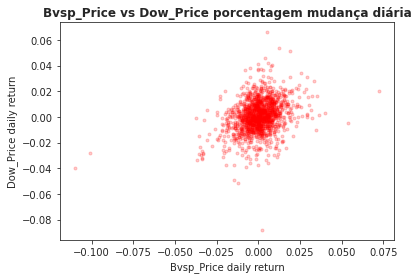

In [ ]:
ax = plt.axes()
plt.plot(dfFinal["Dax_Price"].pct_change(), dfFinal["Bvsp_Price"].pct_change(), "r.", alpha = 0.2)
plt.xlabel("Bvsp_Price daily return")
plt.ylabel("Dow_Price daily return")
plt.title("Bvsp_Price vs Dow_Price porcentagem mudança diária", weight="bold");


Para identificar as relações existestes entre os diferentes indicadores, primeiramente, vamos normalizar os nossos dados, visto que eles tem amplitude totalmente diferentes.


In [ ]:
from sklearn.preprocessing import MaxAbsScaler

p=MaxAbsScaler()

dfFinal_normalizado_fit = p.fit(dfFinal)
dfFinal_normalizado_transform = p.transform(dfFinal)
dfFinal_normalizado = pd.DataFrame(dfFinal_normalizado_transform)

nome_colunas = dfFinal.columns
dfFinal_normalizado.columns = nome_colunas

dfFinal_normalizado

,Bvsp_Volume,Bvsp_Variance,Bvsp_Price,Gold_Volume,Gold_Variance,Gold_Price,Ptr_Volume,Ptr_Variance,Ptr_Price,Dow_Volume,Dow_Variance,Dow_Price,Sp_Volume,Sp_Variance,Sp_Price,Dax_Volume,Dax_Variance,Dax_Price,Usd_Variance,Usd_Price
0,0.185201,0.139029,0.359556,0.000225,0.140887,0.693479,0.246391,0.339405,0.481089,0.151016,0.266712,0.598666,0.421601,0.266138,0.621188,0.020648,0.276240,0.684097,0.378329,0.926432
1,0.159122,0.045093,0.361928,0.000129,0.045259,0.695607,0.233926,0.224073,0.470750,0.107862,0.093637,0.599005,0.363010,0.097470,0.622437,0.018805,0.119732,0.680105,0.209413,0.947123
2,0.244912,0.093140,0.356416,0.000082,0.088328,0.704315,0.321581,0.431670,0.444575,0.122651,0.200822,0.590203,0.424713,0.179144,0.614274,0.008849,0.090227,0.672406,0.162350,0.944683
3,0.250910,0.122331,0.347218,0.000192,0.129937,0.714507,0.352151,0.355881,0.435414,0.179759,0.252943,0.576504,0.497179,0.255004,0.599715,0.015486,0.100490,0.660429,0.183510,0.943041
4,0.200464,0.085757,0.346510,0.000154,0.132127,0.708121,0.340223,0.280092,0.433975,0.144682,0.200888,0.570651,0.456864,0.230047,0.593215,0.016961,0.141113,0.654156,0.150310,0.948108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,0.235765,0.175717,1.000000,0.000198,0.053289,0.973554,0.151200,0.126865,0.807224,0.159084,0.052973,0.999167,0.211607,0.070649,0.999966,0.648580,0.089800,0.878054,0.140825,0.957844
1453,0.243045,0.205362,0.994292,0.001319,0.000000,0.976456,0.200712,0.120274,0.807748,0.185920,0.055194,1.000000,0.237853,0.074377,1.000000,0.010693,0.068419,0.880714,0.155374,0.951205
1454,0.121248,0.221891,0.984706,0.002367,-0.039411,0.977811,0.248795,0.106765,0.808911,0.185031,0.068576,0.997976,0.222381,0.073589,0.997329,-0.917566,0.016540,0.880702,0.149436,0.940541
1455,-0.014652,0.209104,0.978416,0.002171,-0.026342,0.977513,0.261367,0.134651,0.809559,0.178176,0.103544,0.994888,0.233045,0.094844,0.994483,-1.000000,0.035325,0.874518,0.143486,0.936734


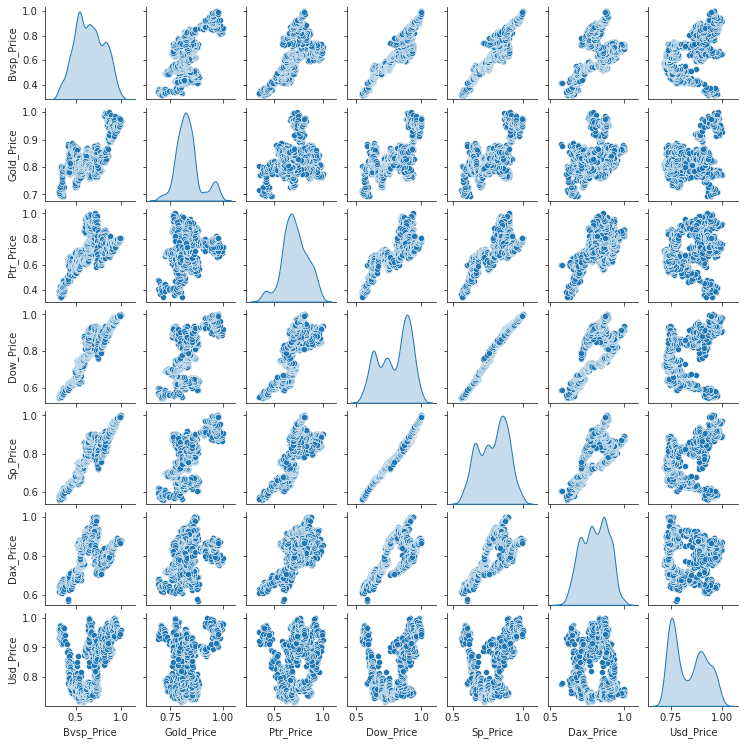

In [ ]:
pair_col1 = ['Bvsp_Price', 'Gold_Price', 'Ptr_Price', 'Dow_Price', 'Sp_Price', 
             'Dax_Price', 'Usd_Price']

def pairplot(df, column_list):
    sns.pairplot(dfFinal_normalizado[column_list], kind='scatter', diag_kind='kde', 
                 height=1.5)
    plt.show()
    
pairplot(dfFinal_normalizado, pair_col1)

Como já era de se esperar, as comodities como o Ouro e o Dólar tem impacto reduzido nos principais indices, visto que seus preços independem do mercado de ações em si. O preço do petróleo apresenta uma certa correlação.

Repetindo os plots para somente os índices BOVESPA, DOW, SP, DAX, e Petróleo:

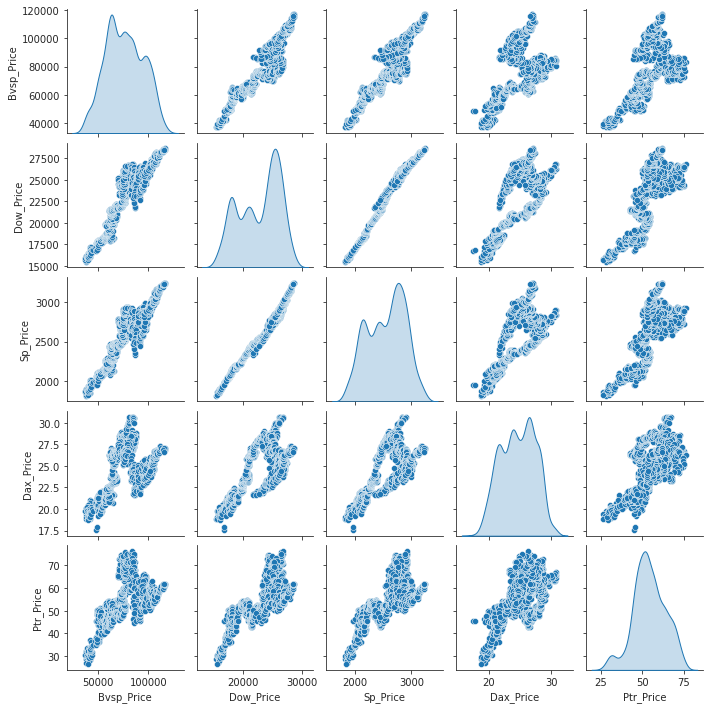

In [ ]:
pair_col1 = ['Bvsp_Price',  'Dow_Price', 'Sp_Price', 
             'Dax_Price','Ptr_Price']

def pairplot(df, column_list):
    sns.pairplot(dfFinal[column_list], kind='scatter', diag_kind='kde', 
                 height=2)
    plt.rcParams['figure.figsize']=(100,100)
    plt.show()
    
pairplot(dfFinal, pair_col1)

Numericamente, pode-se verificar se duas variáveis possuem correlação através do cálculo do **Coeficiente de Pearson**. O coeficiente de Pearson varia de -1 a 1, e pode ser interpretado da seguinte maneira:

- coef = -1 -> perfeita correlação negativa
- coef = 0 -> não há correlação
- coef = 1 -> perfeita correlação positiva.

No python isso pode ser observado num heatmap.

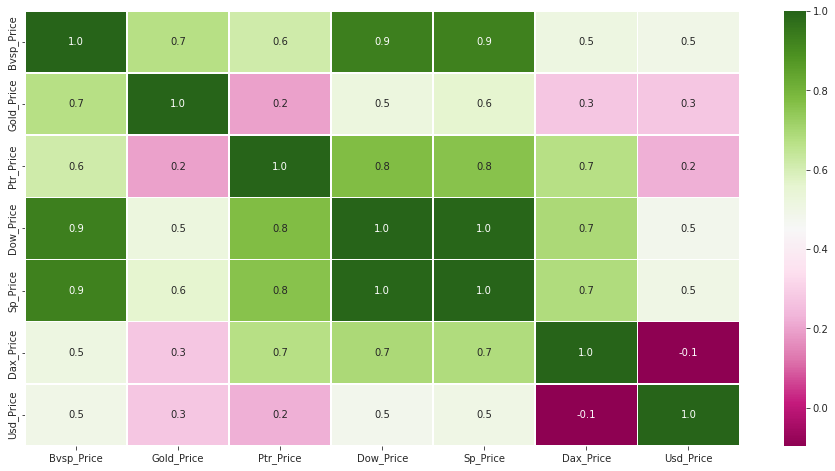

In [ ]:
dfFinal_correlacao = pd.DataFrame(dfFinal, columns = ['Bvsp_Price', 'Gold_Price', 'Ptr_Price', 'Dow_Price', 'Sp_Price', 
             'Dax_Price', 'Usd_Price'])
correlacao=dfFinal_correlacao.corr()

plt.figure(figsize=(16, 8))
plot_pearson = sns.heatmap(correlacao, annot = True, fmt=".1f", linewidths=.6, cmap="PiYG")
plot_pearson

De acordo com o heatmap acima, é possível verificar a independência da variação do valor do ouro com os índices. É interessante notar também que o preço do Ibovespa possui forte correlação positiva com os outros índices.

Agora, ajustamos os índices de dólar para real, visto que estamos estudando a influencia desses índices na Ibovespa, que é em real.

In [ ]:
dfFinal['Dow_Price_Real'] = dfFinal['Dow_Price'] * dfFinal['Usd_Price'] 
dfFinal['Sp_Price_Real'] = dfFinal['Sp_Price'] * dfFinal['Usd_Price'] 
dfFinal['Dax_Price_Real'] = dfFinal['Dax_Price'] * dfFinal['Usd_Price']
dfFinal['Ptr_Price_Real'] = dfFinal['Ptr_Price']* dfFinal['Usd_Price']

dfFinal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1457 entries, 2016-01-04 to 2019-12-30
Freq: D
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Bvsp_Volume     1457 non-null   float64
 1   Bvsp_Variance   1457 non-null   float64
 2   Bvsp_Price      1457 non-null   float64
 3   Gold_Volume     1457 non-null   float64
 4   Gold_Variance   1457 non-null   float64
 5   Gold_Price      1457 non-null   float64
 6   Ptr_Volume      1457 non-null   float64
 7   Ptr_Variance    1457 non-null   float64
 8   Ptr_Price       1457 non-null   float64
 9   Dow_Volume      1457 non-null   float64
 10  Dow_Variance    1457 non-null   float64
 11  Dow_Price       1457 non-null   float64
 12  Sp_Volume       1457 non-null   float64
 13  Sp_Variance     1457 non-null   float64
 14  Sp_Price        1457 non-null   float64
 15  Dax_Volume      1457 non-null   float64
 16  Dax_Variance    1457 non-null   float64
 17  Dax_Pri

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Clonando o dfFinal para a seção de predição posterior

In [ ]:
dfFinalTs=dfFinal.copy(deep=True) #for future Time series analyses
dfFinal2=dfFinal.copy(deep=False)
dfFinalClass=dfFinal.copy(deep=False)

In [ ]:
dfFinalClass

,Bvsp_Volume,Bvsp_Variance,Bvsp_Price,Gold_Volume,Gold_Variance,Gold_Price,Ptr_Volume,Ptr_Variance,Ptr_Price,Dow_Volume,Dow_Variance,Dow_Price,Sp_Volume,Sp_Variance,Sp_Price,Dax_Volume,Dax_Variance,Dax_Price,Usd_Variance,Usd_Price,Dow_Price_Real,Sp_Price_Real,Dax_Price_Real,Ptr_Price_Real
2016-01-04,2.976300e+06,1224.000000,42141.000000,143.000000,19.300049,1075.099976,431985.000000,2.059997,36.759998,1.480600e+08,447.849610,17148.939453,4.304880e+09,48.519897,2012.660034,5600.000000,0.646000,21.006311,0.103700,3.949100,67722.876794,7948.195740,82.956023,145.168908
2016-01-05,2.557200e+06,397.000000,42419.000000,82.000000,6.199951,1078.400024,410131.000000,1.359996,35.970001,1.057500e+08,157.230469,17158.660156,3.706620e+09,17.769897,2016.709961,5100.000000,0.279998,20.883722,0.057400,4.037300,69274.658648,8142.063126,84.313851,145.221685
2016-01-06,3.935900e+06,820.000000,41773.000000,52.000000,12.099975,1091.900024,563811.000000,2.619999,33.970001,1.202500e+08,337.210937,16906.509766,4.336660e+09,32.659912,1990.260010,2400.000000,0.211001,20.647303,0.044500,4.026900,68080.824177,8014.578034,83.144624,136.793797
2016-01-07,4.032300e+06,1077.000000,40695.000000,122.000000,17.800048,1107.699951,617409.000000,2.160000,33.270000,1.762400e+08,424.728516,16514.099609,5.076590e+09,46.489990,1943.089966,4200.000000,0.235000,20.279541,0.050300,4.019900,66385.029018,7811.027354,81.521727,133.742073
2016-01-08,3.221600e+06,755.000000,40612.000000,98.000000,18.099976,1097.800049,596496.000000,1.700001,33.160000,1.418500e+08,337.320312,16346.450195,4.664940e+09,41.940063,1922.030029,4600.000000,0.330000,20.086901,0.041200,4.041500,66064.178463,7767.884362,81.181210,134.016140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,3.788900e+06,1547.000000,117203.000000,126.000000,7.300049,1509.300049,265091.000000,0.770001,61.680000,1.559700e+08,88.949218,28621.390625,2.160680e+09,12.880127,3239.909912,175900.000000,0.210001,26.962070,0.038600,4.083000,116861.137922,13228.552171,110.086132,251.839440
2019-12-27,3.905900e+06,1808.000000,116534.000000,839.000000,0.000000,1513.800049,351899.000000,0.729999,61.720001,1.822800e+08,92.679687,28645.259766,2.428670e+09,13.559815,3240.020020,2900.000000,0.160000,27.043758,0.042588,4.054700,116147.934773,13137.309175,109.654326,250.256088
2019-12-28,1.948542e+06,1953.516496,115410.506681,1505.188773,-5.398937,1515.900168,436199.365190,0.648006,61.808916,1.814084e+08,115.148742,28587.269954,2.270689e+09,13.416078,3231.367154,-248851.314981,0.038679,27.043391,0.040960,4.009246,114613.394199,12955.345437,108.423603,247.807140
2019-12-29,-2.354683e+05,1840.940426,114673.289634,1380.552023,-3.608618,1515.437770,458240.941344,0.817255,61.858443,1.746881e+08,173.865524,28498.814112,2.379576e+09,17.291162,3222.145407,-271208.052492,0.082609,26.853490,0.039330,3.993015,113796.190761,12866.074775,107.226385,247.001687


# Verificação de estacionariedade

Por se tratar de uma série temporal, podemos verificar a sua **estacionariedade**, que se trata da avaliação das suas propriedades estatísticas ao longo do tempo. Basicamente, para uma série temporal ser estacionária, ela deve conter:
- Média constante;
- Variância constante;
- Autocovariância (correlação cruzada com os próprios dados - autocorrelação). [2]

Além da análise gráfica de tendência de crescimento ou decrescimento, pode-se realizar duas técnicas:


In [ ]:
dfFinal.head()

,Bvsp_Volume,Bvsp_Variance,Bvsp_Price,Gold_Volume,Gold_Variance,Gold_Price,Ptr_Volume,Ptr_Variance,Ptr_Price,Dow_Volume,Dow_Variance,Dow_Price,Sp_Volume,Sp_Variance,Sp_Price,Dax_Volume,Dax_Variance,Dax_Price,Usd_Variance,Usd_Price,Dow_Price_Real,Sp_Price_Real,Dax_Price_Real,Ptr_Price_Real
2016-01-04,2976300.0,1224.0,42141.0,143.0,19.300049,1075.099976,431985.0,2.059997,36.759998,148060000.0,447.849610,17148.939453,4.304880e+09,48.519897,2012.660034,5600.0,0.646000,21.006311,0.1037,3.9491,67722.876794,7948.195740,82.956023,145.168908
2016-01-05,2557200.0,397.0,42419.0,82.0,6.199951,1078.400024,410131.0,1.359996,35.970001,105750000.0,157.230469,17158.660156,3.706620e+09,17.769897,2016.709961,5100.0,0.279998,20.883722,0.0574,4.0373,69274.658648,8142.063126,84.313851,145.221685
2016-01-06,3935900.0,820.0,41773.0,52.0,12.099975,1091.900024,563811.0,2.619999,33.970001,120250000.0,337.210937,16906.509766,4.336660e+09,32.659912,1990.260010,2400.0,0.211001,20.647303,0.0445,4.0269,68080.824177,8014.578034,83.144624,136.793797
2016-01-07,4032300.0,1077.0,40695.0,122.0,17.800048,1107.699951,617409.0,2.160000,33.270000,176240000.0,424.728516,16514.099609,5.076590e+09,46.489990,1943.089966,4200.0,0.235000,20.279541,0.0503,4.0199,66385.029018,7811.027354,81.521727,133.742073
2016-01-08,3221600.0,755.0,40612.0,98.0,18.099976,1097.800049,596496.0,1.700001,33.160000,141850000.0,337.320312,16346.450195,4.664940e+09,41.940063,1922.030029,4600.0,0.330000,20.086901,0.0412,4.0415,66064.178463,7767.884362,81.181210,134.016140


**1. Plotagem de Rolling Statistics**

Traça-se a média e variância móvel com o tempo, e compara-se com períodos anteriores.

<Figure size 7200x7200 with 0 Axes>

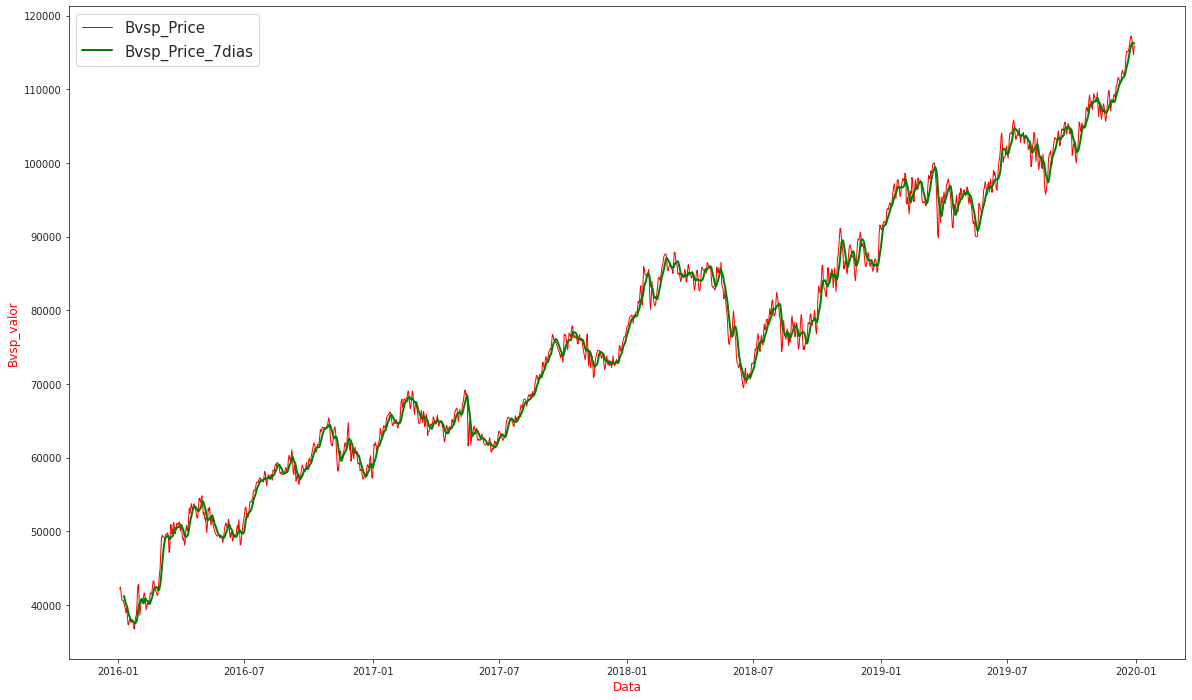

In [ ]:
Bvsp_rolling = dfFinal.Bvsp_Price.rolling(window=7)
Bvsp_rolling_media = Bvsp_rolling.mean()

Dow_rolling = dfFinal.Dow_Price_Real.rolling(window=7)
Dow_rolling_media = Dow_rolling.mean()

Sp_rolling = dfFinal.Sp_Price_Real.rolling(window=7)
Sp_rolling_media = Sp_rolling.mean()

Dax_rolling = dfFinal.Dax_Price_Real.rolling(window=7)
Dax_rolling_media = Dax_rolling.mean()

Ptr_rolling = dfFinal.Ptr_Price_Real.rolling(window=7)
Ptr_rolling_media = Ptr_rolling.mean()

# Exemplo do comportamento gráfico com o valor da Ibovespa

x = dfFinal.index
y1 = dfFinal['Bvsp_Price']
y2 = Bvsp_rolling_media

plt.figure(1)
plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'r', linewidth = 1.0,label='Bvsp_Price')
plt.plot(x, y2, 'g', linewidth =2.0, label='Bvsp_Price_7dias')
plt.xlabel('Data', fontsize='large', color='r')
plt.ylabel('Bvsp_valor', fontsize='large', color='r')
plt.legend(fontsize=15)
plt.show()



<Figure size 7200x7200 with 0 Axes>

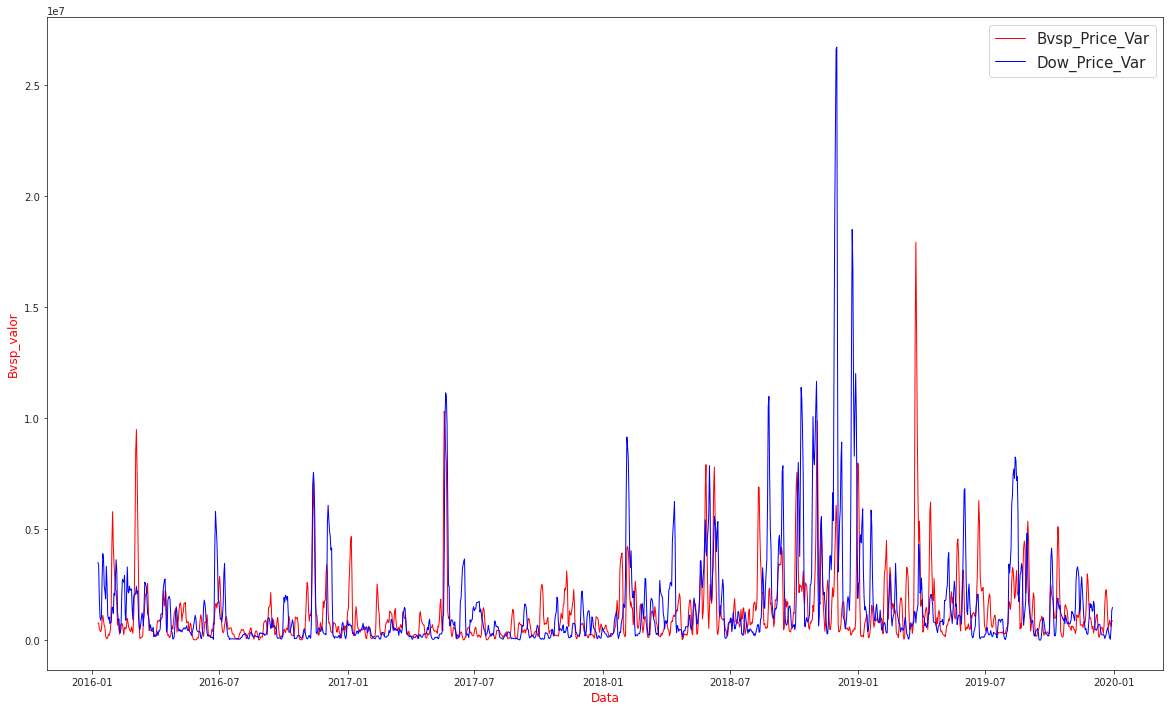

In [ ]:
Bvsp_rolling = dfFinal.Bvsp_Price.rolling(window=7)
Bvsp_rolling_var = Bvsp_rolling.var()

Dow_rolling = dfFinal.Dow_Price_Real.rolling(window=7)
Dow_rolling_var = Dow_rolling.var()

Sp_rolling = dfFinal.Sp_Price_Real.rolling(window=7)
Sp_rolling_var = Sp_rolling.var()

Dax_rolling = dfFinal.Dax_Price_Real.rolling(window=7)
Dax_rolling_var = Dax_rolling.var()

Ptr_rolling = dfFinal.Ptr_Price_Real.rolling(window=7)
Ptr_rolling_var = Ptr_rolling.var()

x = dfFinal.index
y1 = Bvsp_rolling_var
y2 = Dow_rolling_var

plt.figure(1)
plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'r', linewidth = 1.0,label='Bvsp_Price_Var')
plt.plot(x, y2, 'b', linewidth = 1.0,label='Dow_Price_Var')
plt.xlabel('Data', fontsize='large', color='r')
plt.ylabel('Bvsp_valor', fontsize='large', color='r')
plt.legend(fontsize=15)
plt.show()

# Exemplo do comportamento gráfico com o valor da Ibovespa e Dow




De acordo com os gráficos é possível perceber, pela média móvel, que não há uma constância entre os valores; enquanto pelos gráficos de var móvel, que há grande variabilidade entre os valores de acordo com o tempo. Assim, é indicada uma forte não-estacionariedade dos dados, como previsto.

**2. Teste Dickey-Fuller**

Parte-se da hipótese nula de que a série temporal é não-estacionária. De forma simplificada, o parâmetro avaliado é denominado Rho, que indica o quanto não estacionário aqueles dados são. Quanto maior o Rho, menor a estacionariedade [3]

p-value > 0.05: Falha em rejeitar a hipótese nula (H0) - Dados não estacionários.


p-value <= 0.05: Rejeita a hipótese nula - Dados estacionários. [4]

In [ ]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller

print ('Ibovespa:')

Bvsp_series = dfFinal.Bvsp_Price
Bvsp_X = Bvsp_series.values
Bvsp_result = adfuller(Bvsp_X)
print('ADF Statistic: %f' % Bvsp_result[0])
print('p-value: %f' % Bvsp_result[1])
print('Critical Values:')
print (f'dados para Ibovespa')
for key, value in Bvsp_result[4].items():
	print('\t%s: %.3f' % (key, value))
 
print ('\t')
print ('DOW:')
 
Dow_series = dfFinal.Dow_Price_Real
Dow_X = Dow_series.values
Dow_result = adfuller(Dow_X)
print('ADF Statistic: %f' % Dow_result[0])
print('p-value: %f' % Dow_result[1])
print('Critical Values:')
print (f'dados para Dow')
for key, value in Dow_result[4].items():
	print('\t%s: %.3f' % (key, value))
 
print ('\t')
print ('S&P:')

Sp_series = dfFinal.Sp_Price_Real
Sp_X = Sp_series.values
Sp_result = adfuller(Sp_X)
print('ADF Statistic: %f' % Sp_result[0])
print('p-value: %f' % Sp_result[1])
print('Critical Values:')
print (f'dados para S&P')
for key, value in Sp_result[4].items():
	print('\t%s: %.3f' % (key, value))
 
 
print ('\t')
print ('Dax:')

Dax_series = dfFinal.Dax_Price_Real
Dax_X = Dax_series.values
Dax_result = adfuller(Dax_X)
print('ADF Statistic: %f' % Dax_result[0])
print('p-value: %f' % Dax_result[1])
print('Critical Values:')
print (f'dados para Dax')
for key, value in Dax_result[4].items():
	print('\t%s: %.3f' % (key, value))
 
 

Ibovespa:
ADF Statistic: -0.431441
p-value: 0.904715
Critical Values:
dados para Ibovespa
	1%: -3.435
	5%: -2.864
	10%: -2.568
	
DOW:
ADF Statistic: -0.068640
p-value: 0.952474
Critical Values:
dados para Dow
	1%: -3.435
	5%: -2.864
	10%: -2.568
	
S&P:
ADF Statistic: 0.129421
p-value: 0.968013
Critical Values:
dados para S&P
	1%: -3.435
	5%: -2.864
	10%: -2.568
	
Dax:
ADF Statistic: -0.917931
p-value: 0.782010
Critical Values:
dados para Dax
	1%: -3.435
	5%: -2.864
	10%: -2.568


Como o p-valor é significativamente maior para todos os índices, percebe-se que eles apresentam uma esperada não-estacionariedade.

# Predição dos preços dos índices

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

Para prever os dados do dia seguinte a partir dos dados atuais, podemos criar mais métricas para auxiliar, como a média móvel de 5, 7, 15 e 21 dias.


In [ ]:
dfFinal2['Bvsp_mm5'] = dfFinal2['Bvsp_Price'].rolling(5).mean()
dfFinal2['Bvsp_mm7'] = dfFinal2['Bvsp_Price'].rolling(7).mean()
dfFinal2['Bvsp_mm15'] = dfFinal2['Bvsp_Price'].rolling(15).mean()
dfFinal2['Bvsp_mm21'] = dfFinal2['Bvsp_Price'].rolling(21).mean()

dfFinal2['Dow_mm5'] = dfFinal2['Dow_Price_Real'].rolling(5).mean()
dfFinal2['Dow_mm7'] = dfFinal2['Dow_Price_Real'].rolling(7).mean()
dfFinal2['Dow_mm15'] = dfFinal2['Dow_Price_Real'].rolling(15).mean()
dfFinal2['Dow_mm21'] = dfFinal2['Dow_Price_Real'].rolling(21).mean()

dfFinal2['Sp_mm5'] = dfFinal2['Sp_Price_Real'].rolling(5).mean()
dfFinal2['Sp_mm7'] = dfFinal2['Sp_Price_Real'].rolling(7).mean()
dfFinal2['Sp_mm15'] = dfFinal2['Sp_Price_Real'].rolling(15).mean()
dfFinal2['Sp_mm21'] = dfFinal2['Sp_Price_Real'].rolling(21).mean()

dfFinal2['Dax_mm5'] = dfFinal2['Dax_Price_Real'].rolling(5).mean()
dfFinal2['Dax_mm7'] = dfFinal2['Dax_Price_Real'].rolling(7).mean()
dfFinal2['Dax_mm15'] = dfFinal2['Dax_Price_Real'].rolling(15).mean()
dfFinal2['Dax_mm21'] = dfFinal2['Dax_Price_Real'].rolling(21).mean()

dfFinal2.head()

,Bvsp_Volume,Bvsp_Variance,Bvsp_Price,Gold_Volume,Gold_Variance,Gold_Price,Ptr_Volume,Ptr_Variance,Ptr_Price,Dow_Volume,Dow_Variance,Dow_Price,Sp_Volume,Sp_Variance,Sp_Price,Dax_Volume,Dax_Variance,Dax_Price,Usd_Variance,Usd_Price,Dow_Price_Real,Sp_Price_Real,Dax_Price_Real,Ptr_Price_Real,Bvsp_mm5,Bvsp_mm7,Bvsp_mm15,Bvsp_mm21,Dow_mm5,Dow_mm7,Dow_mm15,Dow_mm21,Sp_mm5,Sp_mm7,Sp_mm15,Sp_mm21,Dax_mm5,Dax_mm7,Dax_mm15,Dax_mm21
2016-01-04,2976300.0,1224.0,42141.0,143.0,19.300049,1075.099976,431985.0,2.059997,36.759998,148060000.0,447.849610,17148.939453,4.304880e+09,48.519897,2012.660034,5600.0,0.646000,21.006311,0.1037,3.9491,67722.876794,7948.195740,82.956023,145.168908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,2557200.0,397.0,42419.0,82.0,6.199951,1078.400024,410131.0,1.359996,35.970001,105750000.0,157.230469,17158.660156,3.706620e+09,17.769897,2016.709961,5100.0,0.279998,20.883722,0.0574,4.0373,69274.658648,8142.063126,84.313851,145.221685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,3935900.0,820.0,41773.0,52.0,12.099975,1091.900024,563811.0,2.619999,33.970001,120250000.0,337.210937,16906.509766,4.336660e+09,32.659912,1990.260010,2400.0,0.211001,20.647303,0.0445,4.0269,68080.824177,8014.578034,83.144624,136.793797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,4032300.0,1077.0,40695.0,122.0,17.800048,1107.699951,617409.0,2.160000,33.270000,176240000.0,424.728516,16514.099609,5.076590e+09,46.489990,1943.089966,4200.0,0.235000,20.279541,0.0503,4.0199,66385.029018,7811.027354,81.521727,133.742073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,3221600.0,755.0,40612.0,98.0,18.099976,1097.800049,596496.0,1.700001,33.160000,141850000.0,337.320312,16346.450195,4.664940e+09,41.940063,1922.030029,4600.0,0.330000,20.086901,0.0412,4.0415,66064.178463,7767.884362,81.181210,134.016140,41528.0,NaN,NaN,NaN,67505.51342,NaN,NaN,NaN,7936.749723,NaN,NaN,NaN,82.623487,NaN,NaN,NaN


Como desejamos fazer a predição do dia seguinte a partir dos dados do dia atual, vamos ajustar os dados para um dia a frente.

In [ ]:
dfFinal2['Bvsp_Price'] = dfFinal2['Bvsp_Price'].shift(-1)
dfFinal2['Dow_Price_Real'] = dfFinal2['Dow_Price_Real'].shift(-1)
dfFinal2['Sp_Price_Real'] = dfFinal2['Sp_Price_Real'].shift(-1)
dfFinal2['Dax_Price_Real'] = dfFinal2['Dax_Price_Real'].shift(-1)

# retirando dados nulos (perdemos os 20 primeiros dias)

dfFinal2.dropna(inplace=True)
dfFinal2 = dfFinal2.reset_index(drop=True)
dfFinal2.head()


,Bvsp_Volume,Bvsp_Variance,Bvsp_Price,Gold_Volume,Gold_Variance,Gold_Price,Ptr_Volume,Ptr_Variance,Ptr_Price,Dow_Volume,Dow_Variance,Dow_Price,Sp_Volume,Sp_Variance,Sp_Price,Dax_Volume,Dax_Variance,Dax_Price,Usd_Variance,Usd_Price,Dow_Price_Real,Sp_Price_Real,Dax_Price_Real,Ptr_Price_Real,Bvsp_mm5,Bvsp_mm7,Bvsp_mm15,Bvsp_mm21,Dow_mm5,Dow_mm7,Dow_mm15,Dow_mm21,Sp_mm5,Sp_mm7,Sp_mm15,Sp_mm21,Dax_mm5,Dax_mm7,Dax_mm15,Dax_mm21
0,3.217059e+06,412.658524,36699.805026,80360.31117,4.678366,1093.553902,610728.390229,2.811309,30.490218,1.620149e+08,221.124285,15694.135071,5.111835e+09,45.422029,1870.064012,-1583.570531,-0.060076,19.769840,-0.046405,4.101253,64962.606074,7676.318480,80.927876,125.048096,37610.612617,37721.009012,38359.689053,39220.626202,65272.084354,65043.809004,64665.019098,65353.630633,7736.649866,7683.730368,7608.263235,7686.972966,81.221602,80.752160,79.884940,80.527738
1,2.672848e+06,308.613212,37497.000000,8.00000,10.000000,1106.199951,606892.000000,3.060002,30.340000,1.232500e+08,206.309570,15885.219727,4.401380e+09,30.310058,1877.079956,1000.000000,0.220000,19.789186,0.004900,4.089500,66090.021434,7781.849097,82.181249,124.075430,37421.573622,37544.266873,38124.856630,38961.521679,65467.057856,65174.963398,64735.584916,65222.189170,7762.732623,7711.897313,7620.898173,7674.026430,81.650305,81.022380,80.043597,80.431160
2,3.607000e+06,919.000000,38376.000000,181.00000,7.399902,1121.699951,642432.000000,3.160000,31.450001,1.182100e+08,292.629883,16167.230469,4.357940e+09,27.939941,1903.630005,2400.000000,0.102001,20.103537,0.061800,4.087900,64844.524215,7657.769156,82.204225,128.564459,37377.573622,37464.266873,37961.323296,38727.140727,65656.817648,65344.721325,64776.068280,65070.539779,7786.007334,7734.488130,7627.581499,7656.873381,81.983164,81.316734,80.132987,80.329607
3,4.648600e+06,1364.000000,38630.000000,168706.00000,2.000000,1116.099976,738551.000000,2.700001,32.299999,1.383500e+08,356.730468,15944.459961,4.754040e+09,44.290039,1882.949951,700.000000,0.006000,20.212994,0.041900,4.066900,65964.263791,7772.053402,81.771800,131.360866,37446.573622,37568.695444,37885.456630,38565.378822,65256.843928,65467.119275,64639.216539,64916.430257,7733.499315,7750.468767,7614.604130,7639.882482,81.826562,81.805285,80.080506,80.284826
4,4.464600e+06,1104.000000,40406.000000,52861.00000,15.899902,1115.599976,833378.000000,3.080000,33.220001,1.301200e+08,238.419921,16069.639648,4.693010e+09,29.309937,1893.359985,5400.000000,0.160002,19.920534,0.086000,4.104900,66968.445276,7890.956039,81.337308,136.364782,37630.480390,37699.124016,37864.523296,38467.045488,65245.406427,65584.696607,64702.657048,64896.393817,7711.519109,7765.694175,7625.490678,7638.026579,81.633253,81.984550,80.148050,80.296734


Para checar se realmente não há NaN:

(caso seja False, não há nenhum NaN)


In [ ]:
df_check=dfFinal2.isnull().values.any()
df_check

False

Graficamente podemos verificar, para o Ibovespa, por exemplo, o comportamento das médias móveis com o tempo

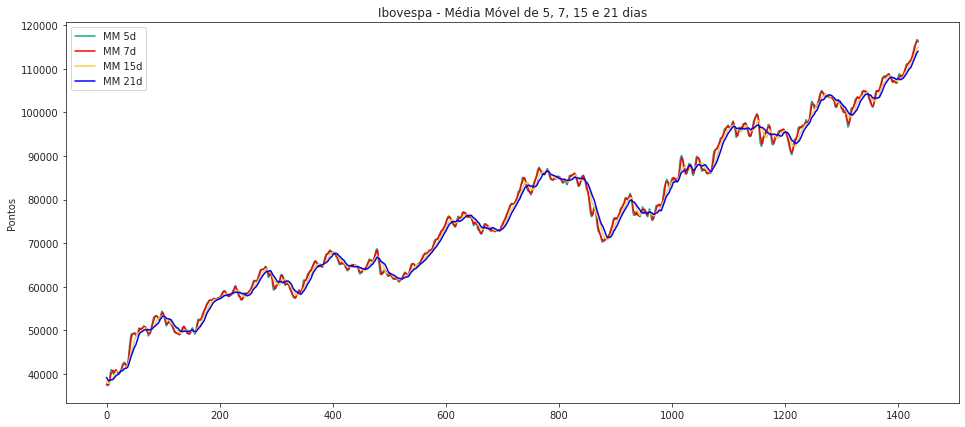

In [ ]:
plt.figure(figsize=(16, 7))
plt.plot(dfFinal2.index, dfFinal2.Bvsp_mm5, color='#17a589', label='MM 5d') # green
plt.plot(dfFinal2.index, dfFinal2.Bvsp_mm7, color='red', label='MM 7d')
plt.plot(dfFinal2.index, dfFinal2.Bvsp_mm15, color='#f4d03f', label='MM 15d') # yellow
plt.plot(dfFinal2.index, dfFinal2.Bvsp_mm21, color='blue', label='MM 21d') 

plt.title("Ibovespa - Média Móvel de 5, 7, 15 e 21 dias")
plt.ylabel("Pontos")
plt.legend()
plt.show()


Verificando o número de linhas totais e quantas serão de teste (30%) e treino (70%):


In [ ]:
n_linhas = len(dfFinal2)
n_linhas_treino= round(.70 * n_linhas)
n_linhas_teste= n_linhas - n_linhas_treino  
n_linhas_validacao = n_linhas -1

print(n_linhas)
print(n_linhas_teste)
print(n_linhas_treino)


1436
431
1005


Separando em features (métricas que serão analisados para prever - input) e label (o preço - output)





In [ ]:
Bvsp_features = pd.DataFrame(dfFinal2, columns = ['Bvsp_mm5', 'Bvsp_mm7', 'Bvsp_mm15', 'Bvsp_mm21', 'Bvsp_Variance', 'Bvsp_Volume'])
Bvsp_labels = dfFinal2['Bvsp_Price']

Dow_features = pd.DataFrame(dfFinal2, columns = ['Dow_mm5', 'Dow_mm7', 'Dow_mm15', 'Dow_mm21', 'Dow_Variance', 'Dow_Volume'])
Dow_labels = dfFinal2['Dow_Price_Real']

Sp_features = pd.DataFrame(dfFinal2, columns = ['Sp_mm5', 'Sp_mm7', 'Sp_mm15', 'Sp_mm21', 'Sp_Variance', 'Sp_Volume'])
Sp_labels = dfFinal2['Sp_Price_Real']

Dax_features = pd.DataFrame(dfFinal2, columns = ['Dax_mm5', 'Dax_mm7', 'Dax_mm15', 'Dax_mm21', 'Dax_Variance', 'Dax_Volume'])
Dax_labels = dfFinal2['Dax_Price_Real']

In [ ]:
dfFinal2.head()

,Bvsp_Volume,Bvsp_Variance,Bvsp_Price,Gold_Volume,Gold_Variance,Gold_Price,Ptr_Volume,Ptr_Variance,Ptr_Price,Dow_Volume,Dow_Variance,Dow_Price,Sp_Volume,Sp_Variance,Sp_Price,Dax_Volume,Dax_Variance,Dax_Price,Usd_Variance,Usd_Price,Dow_Price_Real,Sp_Price_Real,Dax_Price_Real,Ptr_Price_Real,Bvsp_mm5,Bvsp_mm7,Bvsp_mm15,Bvsp_mm21,Dow_mm5,Dow_mm7,Dow_mm15,Dow_mm21,Sp_mm5,Sp_mm7,Sp_mm15,Sp_mm21,Dax_mm5,Dax_mm7,Dax_mm15,Dax_mm21
0,3.217059e+06,412.658524,36699.805026,80360.31117,4.678366,1093.553902,610728.390229,2.811309,30.490218,1.620149e+08,221.124285,15694.135071,5.111835e+09,45.422029,1870.064012,-1583.570531,-0.060076,19.769840,-0.046405,4.101253,64962.606074,7676.318480,80.927876,125.048096,37610.612617,37721.009012,38359.689053,39220.626202,65272.084354,65043.809004,64665.019098,65353.630633,7736.649866,7683.730368,7608.263235,7686.972966,81.221602,80.752160,79.884940,80.527738
1,2.672848e+06,308.613212,37497.000000,8.00000,10.000000,1106.199951,606892.000000,3.060002,30.340000,1.232500e+08,206.309570,15885.219727,4.401380e+09,30.310058,1877.079956,1000.000000,0.220000,19.789186,0.004900,4.089500,66090.021434,7781.849097,82.181249,124.075430,37421.573622,37544.266873,38124.856630,38961.521679,65467.057856,65174.963398,64735.584916,65222.189170,7762.732623,7711.897313,7620.898173,7674.026430,81.650305,81.022380,80.043597,80.431160
2,3.607000e+06,919.000000,38376.000000,181.00000,7.399902,1121.699951,642432.000000,3.160000,31.450001,1.182100e+08,292.629883,16167.230469,4.357940e+09,27.939941,1903.630005,2400.000000,0.102001,20.103537,0.061800,4.087900,64844.524215,7657.769156,82.204225,128.564459,37377.573622,37464.266873,37961.323296,38727.140727,65656.817648,65344.721325,64776.068280,65070.539779,7786.007334,7734.488130,7627.581499,7656.873381,81.983164,81.316734,80.132987,80.329607
3,4.648600e+06,1364.000000,38630.000000,168706.00000,2.000000,1116.099976,738551.000000,2.700001,32.299999,1.383500e+08,356.730468,15944.459961,4.754040e+09,44.290039,1882.949951,700.000000,0.006000,20.212994,0.041900,4.066900,65964.263791,7772.053402,81.771800,131.360866,37446.573622,37568.695444,37885.456630,38565.378822,65256.843928,65467.119275,64639.216539,64916.430257,7733.499315,7750.468767,7614.604130,7639.882482,81.826562,81.805285,80.080506,80.284826
4,4.464600e+06,1104.000000,40406.000000,52861.00000,15.899902,1115.599976,833378.000000,3.080000,33.220001,1.301200e+08,238.419921,16069.639648,4.693010e+09,29.309937,1893.359985,5400.000000,0.160002,19.920534,0.086000,4.104900,66968.445276,7890.956039,81.337308,136.364782,37630.480390,37699.124016,37864.523296,38467.045488,65245.406427,65584.696607,64702.657048,64896.393817,7711.519109,7765.694175,7625.490678,7638.026579,81.633253,81.984550,80.148050,80.296734


Em seguida, escolhe-se os melhores features, pelo método k-best:

In [ ]:
Bvsp_features_list = ('Bvsp_mm5', 'Bvsp_mm7', 'Bvsp_mm15', 'Bvsp_mm21', 'Bvsp_Variance', 'Bvsp_Volume')

Bvsp_k_best_features = SelectKBest(k='all')
Bvsp_k_best_features.fit_transform(Bvsp_features, Bvsp_labels)
Bvsp_k_best_features_scores = Bvsp_k_best_features.scores_
Bvsp_raw_pairs = zip(Bvsp_features_list[1:], Bvsp_k_best_features_scores)
Bvsp_ordered_pairs = list(reversed(sorted(Bvsp_raw_pairs, key=lambda x: x[1])))

Bvsp_k_best_features_final = dict(Bvsp_ordered_pairs[:15])
Bvsp_best_features = Bvsp_k_best_features_final.keys()
print ('')
print ("Melhores features para Bvsp:")
print (Bvsp_k_best_features_final)


Melhores features para Bvsp:
{'Bvsp_mm7': 177.41037853559882, 'Bvsp_mm15': 163.13318647488094, 'Bvsp_mm21': 109.63223990626324, 'Bvsp_Variance': 81.1337247948329, 'Bvsp_Volume': 2.716123872704519}


Para o Bvsp, a média móvel de 7, 15 e 21 dias, e a variância são mais relevantes. Retira-se então a média móvel de 5 dias e o volume.

In [ ]:
Bvsp_features = Bvsp_features.drop(columns=['Bvsp_mm5','Bvsp_Volume'])
Bvsp_features

,Bvsp_mm7,Bvsp_mm15,Bvsp_mm21,Bvsp_Variance
0,37721.009012,38359.689053,39220.626202,412.658524
1,37544.266873,38124.856630,38961.521679,308.613212
2,37464.266873,37961.323296,38727.140727,919.000000
3,37568.695444,37885.456630,38565.378822,1364.000000
4,37699.124016,37864.523296,38467.045488,1104.000000
...,...,...,...,...
1431,115748.670954,113936.062325,113118.166068,1275.593848
1432,116044.670954,114351.995659,113431.547020,1547.000000
1433,116246.528097,114640.928992,113689.070830,1808.000000
1434,116297.306879,114830.629437,113869.954505,1953.516496


In [ ]:
scaler = MinMaxScaler().fit(Bvsp_features)
Bvsp_features_scaler = scaler.transform(Bvsp_features)
Bvsp_features_scaler

array([[0.00325678, 0.00642015, 0.01010215, 0.32992015],
       [0.0010148 , 0.00337539, 0.00667335, 0.32161169],
       [0.        , 0.00125508, 0.00357172, 0.37035365],
       ...,
       [0.99935587, 0.9954564 , 0.99556355, 0.44134405],
       [1.        , 0.997916  , 0.99795723, 0.45296416],
       [0.99889567, 1.        , 1.        , 0.44397448]])

Podemos agora separar o dataset em treinamento e teste:

In [ ]:
Bvsp_X_train = Bvsp_features_scaler[:n_linhas_treino]
Bvsp_X_test = Bvsp_features_scaler[n_linhas_treino:n_linhas_treino + n_linhas_teste -1]

Bvsp_y_train = Bvsp_labels[:n_linhas_treino]
Bvsp_y_test = Bvsp_labels[n_linhas_treino:n_linhas_treino + n_linhas_teste -1]

print( len(Bvsp_X_train), len(Bvsp_y_train))

print( len(Bvsp_X_test), len(Bvsp_y_test))

1005 1005
430 430


Treinamento por **regressão linear**:

In [ ]:
Bvsp_lr = linear_model.LinearRegression()
Bvsp_lr.fit(Bvsp_X_train, Bvsp_y_train)
Bvsp_pred= Bvsp_lr.predict(Bvsp_X_test)
Bvsp_cd =r2_score(Bvsp_y_test, Bvsp_pred)

f'Coeficiente de determinação:{Bvsp_cd * 100:.2f}'

'Coeficiente de determinação:93.95'

Podemos então predizer o valor para a observação do dia seguinte:

In [ ]:
Bvsp_valor_novo = Bvsp_features.tail(1)

Bvsp_previsao = scaler.transform(Bvsp_valor_novo)

Bvsp_pred=Bvsp_lr.predict(Bvsp_previsao)

Bvsp_pred


array([116183.90882975])

Comparando com o valor real:

In [ ]:
Bvsp_real = dfFinal2['Bvsp_Price'].iloc[-1]

Bvsp_dfComp = pd.DataFrame({'Real':Bvsp_real, 'Previsão':Bvsp_pred})
Bvsp_dfComp

,Real,Previsão
0,115964.0,116183.90883


# Classificação - Previsão de Up ou Down

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score 
from scipy.stats import mode




Para transformarmos este problema em um de classificação, verificamos a variação de preço dos índices do dia anterior para o seguinte e criamos colunas representando o comportamento.


In [ ]:
# Criando colunas com classificação de subida ou descida

 # Selecionando as colunas desejadas
col_selecionadas = ['Bvsp_Price', 'Dow_Price_Real', 'Sp_Price_Real','Dax_Price_Real','Ptr_Price_Real']
dfClass = dfFinalClass[col_selecionadas]

 # Criando novas colunas contendo apenas 0, para em seguida manter 0 para descida e 1 para subida
dfClass['Bvsp_Class'] = pd.Series([0 for x in range(len(dfClass.index))], index=dfClass.index)
dfClass['Dow_Class'] = pd.Series([0 for x in range(len(dfClass.index))], index=dfClass.index)
dfClass['Sp_Class'] = pd.Series([0 for x in range(len(dfClass.index))], index=dfClass.index)
dfClass['Dax_Class'] = pd.Series([0 for x in range(len(dfClass.index))], index=dfClass.index)
dfClass['Ptr_Class'] = pd.Series([0 for x in range(len(dfClass.index))], index=dfClass.index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
range(len(dfClass.index))

range(0, 1457)

In [ ]:
#retirando as NAN

dfClass = dfClass.dropna(0)

In [ ]:
i = 1
while i < len(dfClass.index):
  if dfClass.Bvsp_Price[i] - dfClass.Bvsp_Price[i-1] > 0:
    dfClass.Bvsp_Class[i] = 1
  else:
    dfClass.Bvsp_Class[i] = 0

  if dfClass.Dow_Price_Real[i] - dfClass.Dow_Price_Real[i-1] > 0:
    dfClass.Dow_Class[i] = 1
  else:
    dfClass.Dow_Class[i] = 0

  if dfClass.Sp_Price_Real[i] - dfClass.Sp_Price_Real[i-1] > 0:
    dfClass.Sp_Class[i] = 1
  else:
    dfClass.Sp_Class[i] = 0

  if dfClass.Dax_Price_Real[i] - dfClass.Dax_Price_Real[i-1] > 0:
    dfClass.Dax_Class[i] = 1
  else:
    dfClass.Dax_Class[i] = 0
  
  if dfClass.Ptr_Price_Real[i] - dfClass.Ptr_Price_Real[i-1] > 0:
    dfClass.Ptr_Class[i] = 1
  else:
    dfClass.Dax_Class[i] = 0
  i+=1
dfClass


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7

,Bvsp_Price,Dow_Price_Real,Sp_Price_Real,Dax_Price_Real,Ptr_Price_Real,Bvsp_Class,Dow_Class,Sp_Class,Dax_Class,Ptr_Class
2016-01-04,42419.000000,69274.658648,8142.063126,84.313851,145.168908,0,0,0,0,0
2016-01-05,41773.000000,68080.824177,8014.578034,83.144624,145.221685,0,0,0,0,1
2016-01-06,40695.000000,66385.029018,7811.027354,81.521727,136.793797,0,0,0,0,0
2016-01-07,40612.000000,66064.178463,7767.884362,81.181210,133.742073,0,0,0,0,0
2016-01-08,40597.814431,64923.389719,7618.735137,79.690962,134.016140,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-12-25,117203.000000,116861.137922,13228.552171,110.086132,251.521821,1,1,1,1,1
2019-12-26,116534.000000,116147.934773,13137.309175,109.654326,251.839440,0,0,0,0,1
2019-12-27,115410.506681,114613.394199,12955.345437,108.423603,250.256088,0,0,0,0,0
2019-12-28,114673.289634,113796.190761,12866.074775,107.226385,247.807140,0,0,0,0,0


In [ ]:
# Contagem de descidas (0) e subidas (1)
dfClass['Bvsp_Class'].value_counts(dropna=False, normalize=True)

1    0.526099
0    0.473901
Name: Bvsp_Class, dtype: float64

In [ ]:
dfClass['Dow_Class'].value_counts(dropna=False, normalize=True)

1    0.506181
0    0.493819
Name: Dow_Class, dtype: float64

In [ ]:
dfClass['Sp_Class'].value_counts(dropna=False, normalize=True)

1    0.501374
0    0.498626
Name: Sp_Class, dtype: float64

In [ ]:
dfClass['Dax_Class'].value_counts(dropna=False, normalize=True)

0    0.729396
1    0.270604
Name: Dax_Class, dtype: float64

In [ ]:
dfClass['Ptr_Class'].value_counts(dropna=False, normalize=True)

1    0.51511
0    0.48489
Name: Ptr_Class, dtype: float64

Todas os parâmetros, com exceção do Dax, apresentaram classificações equilibradas.

In [ ]:
# Valores que serão utilizados no teste = valores do dia anterior das bolsas Dow, Sp, Dax e o preço de petróleo
# Utilizando o shift podemos subir uma linha dos valores do dia anterior para utilizar na predição do dia seguinte

col_selecionadas2 = ['Bvsp_Class', 'Dow_Class', 'Sp_Class','Dax_Class','Ptr_Class']
dfClass2 = dfClass[col_selecionadas2]
dfClass2

,Bvsp_Class,Dow_Class,Sp_Class,Dax_Class,Ptr_Class
2016-01-04,0,0,0,0,0
2016-01-05,0,0,0,0,1
2016-01-06,0,0,0,0,0
2016-01-07,0,0,0,0,0
2016-01-08,0,0,0,0,1
...,...,...,...,...,...
2019-12-25,1,1,1,1,1
2019-12-26,0,0,0,0,1
2019-12-27,0,0,0,0,0
2019-12-28,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

variaveis = ['Dow_Class', 'Sp_Class','Dax_Class','Ptr_Class']
X = dfClass[variaveis].reset_index(drop=True)
y = dfClass['Bvsp_Class'].reset_index(drop=True)

# Divisão dos dados em teste e treino
# stratify = y por causa do Dax

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=20, stratify=y)

In [ ]:
# Cross-Validation
def train_test_cv_rf(X, y, num_folds = 10):
    
    model_list = []
    acuracia_list = []
    precision_list = []
    recall_list = []
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state = 20)
    
# A função RandomForestClassifier realiza o fit de diversas árvores de decisão a partir 
# de diversos subsamples
#     n_estimators: por padrão, utiliza-se 100
#     max_depth: indica a profundidade da árvore, caso esse parâmetro esteja muito alto, pode causar overfitting
#                caso esteja como None, automaticamente expande os nós até que as folhas sejam puras
#     random_state: utilizado para garantir reprodutibilidade
#     max_features: o número de features para garantir a melhor divisão: quando em 'sqrt': max_features=sqrt(n_features)
#     criterion: mede a qualidade do split, quando em 'entropy' o critério é o ganho de informação
#     class_weight: quando em 'balanced' balanceia o y de acordo com a frequência de x  

    rf = RandomForestClassifier(n_estimators = 100,
                                max_depth=None,
                                random_state=20,
                                max_features= 'sqrt',
                                criterion='entropy',
                                class_weight='balanced')

    for train_index, test_index in kf.split(X):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        
        rf.fit(X_train, y_train.values)
        y_pred = rf.predict(X_test)
        
        acuracia = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
                
        model_list.append(rf)
        acuracia_list.append(acuracia)
        precision_list.append(precision)
        recall_list.append(recall)
    
       
    return acuracia_list, precision_list, recall_list, model_list



Antes de entender as métricas, é importante relembrar o conceito da matrix de confusão. A matriz de confusão indica a quantidade de Verdadeiros Positivos (VP), Verdadeiros Negativos (VN), Falso Positivo (FP - Erro tipo I - previu Positivo, mas a classe é Negativo) e Falso Negativo (FN - Erro tipo II - previu Negativo, mas a classe é Positivo) [5].


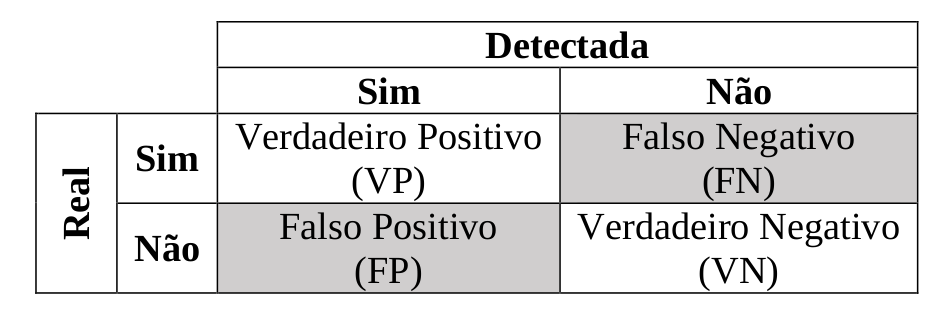


Acurácia, Precisão, Revocação (Recall) e F1 Score são métricas de avaliação de modelos de classificação [5]:

- **Acurácia**: indica quantas classificações o modelo classificou corretamente.
      Acurácia = (VP + VN) / (VP + VN + FP + FN)
      A Acurácia pode ser enganosa em situações de desabalanço entre classes.
     
- **Precisão**: indica as classificações da classe Positivo que estão corretas
      Precisão = VP/(VP + FP)
      Bastante útil quando os FP são mais indesejáveis que os FN.
      
- **Revocação (Recall):** indica, quando o Positivo é o valor esperado, quantas classificações foram corretas.
      Revocação = VP/(VP + FN)
      Bastante útil quando os FN são mais indesejáveis que os FP.

- **F1-Score:** média harmônica entre precisão e revocação.
      F1-Score = 2*Precisão*Revocação/(Precisão+ Recall)
      Quando o F1-Score está baixo ou a precisão ou a revocação está baixo.


O número de Folds geralmente é 5 ou 10, para o atual problema, 10 apresentou melhores valores na matriz de confusão final.

In [ ]:
acuracia_list, precision_list, recall_list, model_list = train_test_cv_rf(X_train, y_train, num_folds=10)

In [ ]:
acuracia_list

[0.6470588235294118,
 0.5882352941176471,
 0.5196078431372549,
 0.6176470588235294,
 0.5980392156862745,
 0.6274509803921569,
 0.5098039215686274,
 0.6764705882352942,
 0.6274509803921569,
 0.6534653465346535]

Podemos verificar também qual das variáveis apresentou maior influência no modelo. A variação na bolsa DOW apresentou maior influência, ainda que não se saiba se foi no crescimento ou decrescimento do valor.

In [ ]:
best_arg_rf = mode([np.argmax(acuracia_list), np.argmax(precision_list), np.argmax(recall_list)])[0][0]

best_model_rf = model_list[best_arg_rf]

In [ ]:
best_model_rf.feature_importances_

array([0.53605862, 0.24619931, 0.10985769, 0.10788438])

<Figure size 432x288 with 0 Axes>

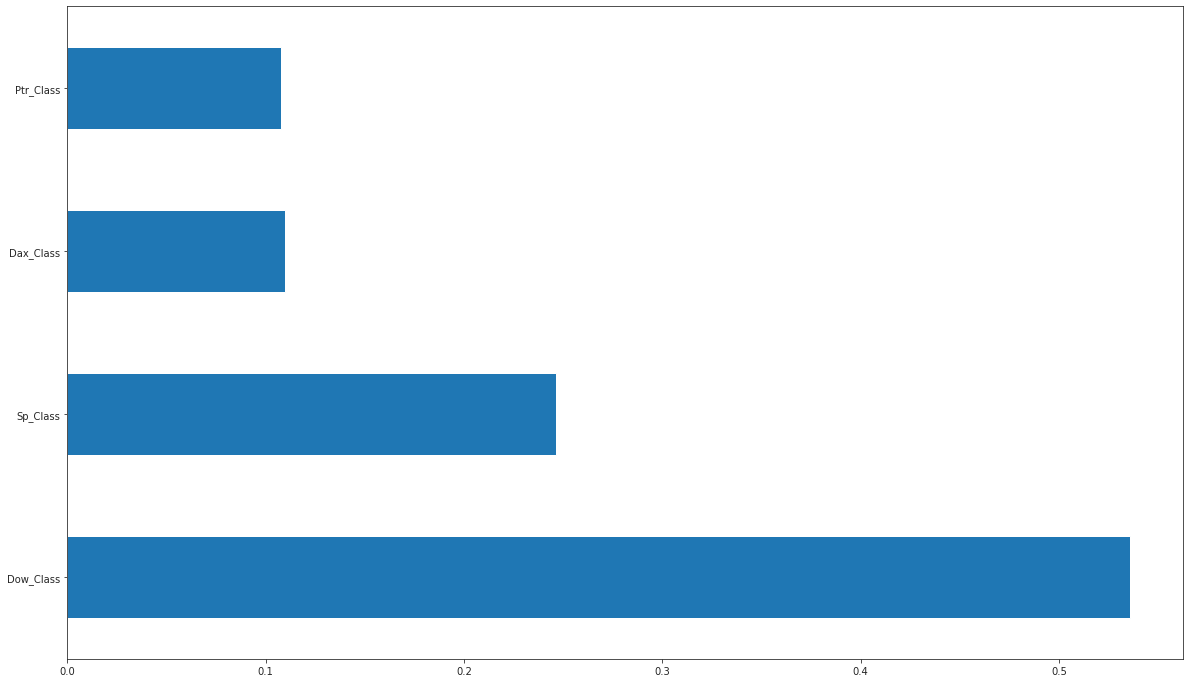

In [ ]:
importances = pd.Series(best_model_rf.feature_importances_, index=X_train.columns)
plt.figure(1)
plt.figure(figsize=(20, 12))
importances.nlargest(20).plot(kind='barh')

A **matriz de confusão** pode, finalmente, ser construída:

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = best_model_rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['Down', 'Up']))

[[120  87]
 [ 89 141]]
              precision    recall  f1-score   support

        Down       0.57      0.58      0.58       207
          Up       0.62      0.61      0.62       230

    accuracy                           0.60       437
   macro avg       0.60      0.60      0.60       437
weighted avg       0.60      0.60      0.60       437



De maneira geral, pode-se perceber que as métricas foram similares para o crescimento e decrescimento do valor do Ibovespa. Como o problema se trata sobre bolsa de valores, a mínima vantagem estatística sobre o conhecimento do comportamento dos valores já é suficiente.

Como o problema traz valores de classificação similares (exceto para a bolsa DAX que apresenta um certo desbalanceamento), a acurácia pode ser levada em consideração, apresentando 0,6. Em problemas de bolsas de valores, o falso positivo pode ser mais perigoso que o falso negativo, logo, a precisão é mais útil que a revocação (recall), apesar de que, neste caso, ambos apresentam valores similares entre 0,58 e 0,62.

# Modelos Automatizados de Séries temporais

In [ ]:
dfFinalTs.head()

,Bvsp_Volume,Bvsp_Variance,Bvsp_Price,Gold_Volume,Gold_Variance,Gold_Price,Ptr_Volume,Ptr_Variance,Ptr_Price,Dow_Volume,Dow_Variance,Dow_Price,Sp_Volume,Sp_Variance,Sp_Price,Dax_Volume,Dax_Variance,Dax_Price,Usd_Variance,Usd_Price,Dow_Price_Real,Sp_Price_Real,Dax_Price_Real,Ptr_Price_Real
2016-01-04,2976300.0,1224.0,42141.0,143.0,19.300049,1075.099976,431985.0,2.059997,36.759998,148060000.0,447.849610,17148.939453,4.304880e+09,48.519897,2012.660034,5600.0,0.646000,21.006311,0.1037,3.9491,67722.876794,7948.195740,82.956023,145.168908
2016-01-05,2557200.0,397.0,42419.0,82.0,6.199951,1078.400024,410131.0,1.359996,35.970001,105750000.0,157.230469,17158.660156,3.706620e+09,17.769897,2016.709961,5100.0,0.279998,20.883724,0.0574,4.0373,69274.658648,8142.063126,84.313859,145.221685
2016-01-06,3935900.0,820.0,41773.0,52.0,12.099975,1091.900024,563811.0,2.619999,33.970001,120250000.0,337.210937,16906.509766,4.336660e+09,32.659912,1990.260010,2400.0,0.211001,20.647305,0.0445,4.0269,68080.824177,8014.578034,83.144633,136.793797
2016-01-07,4032300.0,1077.0,40695.0,122.0,17.800048,1107.699951,617409.0,2.160000,33.270000,176240000.0,424.728516,16514.099609,5.076590e+09,46.489990,1943.089966,4200.0,0.235000,20.279541,0.0503,4.0199,66385.029018,7811.027354,81.521727,133.742073
2016-01-08,3221600.0,755.0,40612.0,98.0,18.099976,1097.800049,596496.0,1.700001,33.160000,141850000.0,337.320312,16346.450195,4.664940e+09,41.940063,1922.030029,4600.0,0.330000,20.086903,0.0412,4.0415,66064.178463,7767.884362,81.181218,134.016140


Para as análises de séries temporais podemos ignorar os índices em reais, visto que os modelos tem acesso ao valor do dolar e podem realizar essa compensação caso resulte em um melhor modelo.

In [ ]:
dfFinalTs.drop(['Dow_Price_Real', 'Sp_Price_Real', 'Dax_Price_Real','Ptr_Price_Real'], axis=1)


,Bvsp_Volume,Bvsp_Variance,Bvsp_Price,Gold_Volume,Gold_Variance,Gold_Price,Ptr_Volume,Ptr_Variance,Ptr_Price,Dow_Volume,Dow_Variance,Dow_Price,Sp_Volume,Sp_Variance,Sp_Price,Dax_Volume,Dax_Variance,Dax_Price,Usd_Variance,Usd_Price
2016-01-04,2.976300e+06,1224.000000,42141.000000,143.000000,19.300049,1075.099976,431985.000000,2.059997,36.759998,1.480600e+08,447.849610,17148.939453,4.304880e+09,48.519897,2012.660034,5600.000000,0.646000,21.006311,0.103700,3.949100
2016-01-05,2.557200e+06,397.000000,42419.000000,82.000000,6.199951,1078.400024,410131.000000,1.359996,35.970001,1.057500e+08,157.230469,17158.660156,3.706620e+09,17.769897,2016.709961,5100.000000,0.279998,20.883724,0.057400,4.037300
2016-01-06,3.935900e+06,820.000000,41773.000000,52.000000,12.099975,1091.900024,563811.000000,2.619999,33.970001,1.202500e+08,337.210937,16906.509766,4.336660e+09,32.659912,1990.260010,2400.000000,0.211001,20.647305,0.044500,4.026900
2016-01-07,4.032300e+06,1077.000000,40695.000000,122.000000,17.800048,1107.699951,617409.000000,2.160000,33.270000,1.762400e+08,424.728516,16514.099609,5.076590e+09,46.489990,1943.089966,4200.000000,0.235000,20.279541,0.050300,4.019900
2016-01-08,3.221600e+06,755.000000,40612.000000,98.000000,18.099976,1097.800049,596496.000000,1.700001,33.160000,1.418500e+08,337.320312,16346.450195,4.664940e+09,41.940063,1922.030029,4600.000000,0.330000,20.086903,0.041200,4.041500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,3.788900e+06,1547.000000,117203.000000,126.000000,7.300049,1509.300049,265091.000000,0.770001,61.680000,1.559700e+08,88.949218,28621.390625,2.160680e+09,12.880127,3239.909912,175900.000000,0.210001,26.962069,0.038600,4.083000
2019-12-27,3.905900e+06,1808.000000,116534.000000,839.000000,0.000000,1513.800049,351899.000000,0.729999,61.720001,1.822800e+08,92.679687,28645.259766,2.428670e+09,13.559815,3240.020020,2900.000000,0.160000,27.043758,0.042588,4.054700
2019-12-28,1.948542e+06,1953.516496,115410.506681,1505.188773,-5.398937,1515.900168,436199.365190,0.648006,61.808916,1.814084e+08,115.148742,28587.269954,2.270689e+09,13.416078,3231.367154,-248851.314981,0.038679,27.043392,0.040960,4.009246
2019-12-29,-2.354683e+05,1840.940426,114673.289634,1380.552023,-3.608618,1515.437770,458240.941344,0.817255,61.858443,1.746881e+08,173.865524,28498.814112,2.379576e+09,17.291162,3222.145407,-271208.052492,0.082609,26.853491,0.039330,3.993015


In [ ]:
dfFinalTs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1457 entries, 2016-01-04 to 2019-12-30
Freq: D
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Bvsp_Volume     1457 non-null   float64
 1   Bvsp_Variance   1457 non-null   float64
 2   Bvsp_Price      1457 non-null   float64
 3   Gold_Volume     1457 non-null   float64
 4   Gold_Variance   1457 non-null   float64
 5   Gold_Price      1457 non-null   float64
 6   Ptr_Volume      1457 non-null   float64
 7   Ptr_Variance    1457 non-null   float64
 8   Ptr_Price       1457 non-null   float64
 9   Dow_Volume      1457 non-null   float64
 10  Dow_Variance    1457 non-null   float64
 11  Dow_Price       1457 non-null   float64
 12  Sp_Volume       1457 non-null   float64
 13  Sp_Variance     1457 non-null   float64
 14  Sp_Price        1457 non-null   float64
 15  Dax_Volume      1457 non-null   float64
 16  Dax_Variance    1457 non-null   float64
 17  Dax_Pri

Vamos então, separar os nossos dados em treino e teste, na proporção 75% /25%

In [ ]:
dfTsTrain = dfFinalTs['2016-01-01':'2019-01-01']
dfTsTest = dfFinal['2019-01-01':'2020-01-01']

In [ ]:
dfTsTrain.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2016-01-04 to 2019-01-01
Freq: D
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Bvsp_Volume     1094 non-null   float64
 1   Bvsp_Variance   1094 non-null   float64
 2   Bvsp_Price      1094 non-null   float64
 3   Gold_Volume     1094 non-null   float64
 4   Gold_Variance   1094 non-null   float64
 5   Gold_Price      1094 non-null   float64
 6   Ptr_Volume      1094 non-null   float64
 7   Ptr_Variance    1094 non-null   float64
 8   Ptr_Price       1094 non-null   float64
 9   Dow_Volume      1094 non-null   float64
 10  Dow_Variance    1094 non-null   float64
 11  Dow_Price       1094 non-null   float64
 12  Sp_Volume       1094 non-null   float64
 13  Sp_Variance     1094 non-null   float64
 14  Sp_Price        1094 non-null   float64
 15  Dax_Volume      1094 non-null   float64
 16  Dax_Variance    1094 non-null   float64
 17  Dax_Pri

In [ ]:
dfTsTest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2019-01-01 to 2019-12-30
Freq: D
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Bvsp_Volume     364 non-null    float64
 1   Bvsp_Variance   364 non-null    float64
 2   Bvsp_Price      364 non-null    float64
 3   Gold_Volume     364 non-null    float64
 4   Gold_Variance   364 non-null    float64
 5   Gold_Price      364 non-null    float64
 6   Ptr_Volume      364 non-null    float64
 7   Ptr_Variance    364 non-null    float64
 8   Ptr_Price       364 non-null    float64
 9   Dow_Volume      364 non-null    float64
 10  Dow_Variance    364 non-null    float64
 11  Dow_Price       364 non-null    float64
 12  Sp_Volume       364 non-null    float64
 13  Sp_Variance     364 non-null    float64
 14  Sp_Price        364 non-null    float64
 15  Dax_Volume      364 non-null    float64
 16  Dax_Variance    364 non-null    float64
 17  Dax_Pric

Para realizarmos a otimização das séries temporais utilizaremos a biblioteca autoTs, ou auto time series. Essa biblioteca realiza a criação, otimização e validação de modelos para séries temporais, para isso, ela utiliza diversos tipos de modelos, como Arima, Sarima, AverageValueNaive e etc. Em seguida, essa biblioteca também testa tecnicas de ensemble com combinação dos modelos criados, afim de tentar melhorar ainda mais o modelo final.

In [ ]:
!pip install autots #instalação da biblioteca autots

     |████████████████████████████████| 441 kB 5.4 MB/s 


In [ ]:
from autots import AutoTS #importar a biblioteca
import pandas as pd

Como nosso dataframe tem diversos dados, daremos um peso maior a variável que queremos realizar a predição.

In [ ]:
peso = {'Bvsp_price': 20}

Em seguida, precisamos determinar uma métrica para validação dos modelos, para isso, o algoritmo usa uma combinação de métricas, nesse caso, manteremos os pesos padrão dessa biblioteca.

In [ ]:
metric_weighting = {
    'smape_weighting': 10,
    'mae_weighting': 2,
    'rmse_weighting': 4,
    'containment_weighting': 0,
    'runtime_weighting': 0,
    'spl_weighting': 0,
    'contour_weighting': 0,
}

Podemos também determinar quais modelos de séries temporais queremos utilizar. Ou utilizar alguns Presets. Nesse exemplos vamos expecificar os modelos multivariaveis e que não precisem de muito poder computacional, visto que alguns modelos podem levar horas para serem gerados. Lista completa (https://winedarksea.github.io/AutoTS/build/html/source/tutorial.html#id8)

In [ ]:
modelList = [
    'LastValueNaive',
    'AverageValueNaive',
    'VAR',
    'ZeroesNaive',
    'ARIMA',
    'GLS',
]

Finalmente, podemos configurar a criação dos modelos. Para isso, utilizaremos um tamanho de previsão de 364 (tamanho dos dados de teste), intervalo de predição de 0.7 (para aumentar a velocidade de processamento), ensemble simples, número de gerações de 10 e 3 ciclo de validação para os 50 melhores modelos. Em seguida, podemos treinar esses modelos.

In [ ]:
model = AutoTS(
    forecast_length=364,
    frequency='infer',
    prediction_interval=0.7,
    ensemble='simple',
    model_list= "superfast",  # "superfast", "default", "fast_parallel"
    transformer_list="superfast",  # "superfast",
    max_generations=10,
    num_validations=1,
    validation_method="backwards",
    models_to_validate=50,
    n_jobs="auto",
    random_seed=321,
    metric_weighting = metric_weighting,
)
model = model.fit(
    dfTsTrain,
    weights=peso,
)


Using 0 cpus for n_jobs.
Inferred frequency is: D
Model Number: 1 with model AverageValueNaive in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model GLS in generation 0 of 10
Model Number: 5 with model GLS in generation 0 of 10
Model Number: 6 with model LastValueNaive in generation 0 of 10
Model Number: 7 with model LastValueNaive in generation 0 of 10
Model Number: 8 with model LastValueNaive in generation 0 of 10
Model Number: 9 with model LastValueNaive in generation 0 of 10
Model Number: 10 with model SeasonalNaive in generation 0 of 10
Model Number: 11 with model SeasonalNaive in generation 0 of 10
Model Number: 12 with model SeasonalNaive in generation 0 of 10
Model Number: 13 with model SeasonalNaive in generation 0 of 10
Model Number: 14 with model ZeroesNaive in generation 0 of 10
Model Number: 15 with model ZeroesNaive in generation 0 of 10
Model N

Melhor modelo e transformações:

In [ ]:
print(model)

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 3, 'model_metric': 'cluster_4', 'models': {'e7f41fb557288361234d9a1b482a1d99': {'Model': 'LastValueNaive', 'ModelParameters': '{}', 'TransformationParameters': '{"fillna": "rolling_mean", "transformations": {"0": "Detrend", "1": "StandardScaler", "2": "MaxAbsScaler", "3": "StandardScaler"}, "transformation_params": {"0": {"model": "GLS"}, "1": {}, "2": {}, "3": {}}}'}, 'b3c75a13c6e49ec6c8a7ad9290f751a8': {'Model': 'ZeroesNaive', 'ModelParameters': '{}', 'TransformationParameters': '{"fillna": "fake_date", "transformations": {"0": "Detrend", "1": "Detrend", "2": "DifferencedTransformer"}, "transformation_params": {"0": {"model": "GLS"}, "1": {"model": "GLS"}, "2": {}}}'}, 'cbdbedb8c576202ed756f0c747a67dc3': {'Model': 'AverageValueNaive', 'ModelParameters': '{"method": "Weighted_Mean"}', 'TransformationParameters': '{"fillna": "fake_date", "transformations": {"0": "MaxAbsScaler", "1": "Discretize

Gerando resultado gráfico

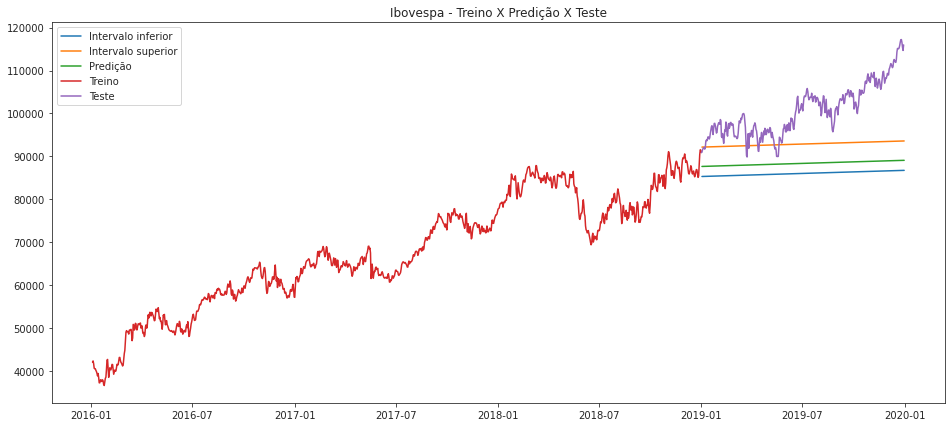

In [ ]:
prediction = model.predict()
forecasts_df = prediction.forecast
forecasts_upper_df = prediction.upper_forecast
forecasts_lower_df = prediction.lower_forecast
plt.figure(figsize=(16, 7))
plt.plot(forecasts_lower_df['Bvsp_Price'], label='Intervalo inferior')
plt.plot(forecasts_upper_df['Bvsp_Price'], label='Intervalo superior')
plt.plot(forecasts_df['Bvsp_Price'], label='Predição')
plt.plot(dfTsTrain['Bvsp_Price'], label='Treino')
dfPlotTest = dfTsTest['Bvsp_Price']['2019-01-01':'2020-01-01']
plt.plot(dfPlotTest, label='Teste')
plt.legend(loc="upper left")
plt.title("Ibovespa - Treino X Predição X Teste")

plt.show()

# Conclusão

Apesar dos modelos de classificação e de séries temporais apontarem para resultados marginalmente positivos é importante notar que realizar previsão para um período tão grande não é a melhor aproximação para esse problema, no caso ideal, esses modelos deveriam ser calculados diariamente e realizar somente a previsão de um dia, e no dia seguinte ser recalculado, visto que sistemas financeiros tem muitos componentes randômicos que atrapalham analises a longo prazo.

# Referências

[1] http://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm

[2] https://www.vooo.pro/insights/guia-completo-para-criar-time-series-com-codigo-em-python/

[3] https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

[4] https://machinelearningmastery.com/time-series-data-stationary-python/

[5] https://vitorborbarodrigues.medium.com/métricas-de-avaliação-acurácia-precisão-recall-quais-as-diferenças-c8f05e0a513c